# imports

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import functools
import collections
import glob
import itertools
import multiprocessing
import pickle
import re
import os
import sys
import json
from ast import literal_eval

import numpy as onp
import pandas as pd
import plotnine as gg
from ray.tune import Analysis
import jax.numpy as jnp
import jax
import tree

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
plt.rc('pdf',fonttype = 42)
plt.rc('ps',fonttype = 42)
from scipy.spatial import Voronoi, voronoi_plot_2d

from mpl_toolkits.axes_grid1 import make_axes_locatable


sys.path.insert(0, '../')

from common.notebook_utils import (
    load_data,
    get_ckpt_paths,
    seed_mavg,
    parse_str_col,
    explode,
    softplus,
)

import matplotlib.pyplot as plt
%matplotlib inline

# Generating the return surface

In [11]:
experiment_dirs = [
    '~/ray_results/on_policy_bandits:learn_lr_schedule:lt_len_30:noise_2:loss_surface',
]

grad_dfs = []

param_classes = [
    'truncation_length',
    'index_cutoff_ratio',
    'seed',
]

for d in experiment_dirs:
    for path in glob.glob(os.path.join(d, '**/params.json')):
        with open(path, 'r') as f:
            params = pd.json_normalize(json.load(f))
        eta_init = params['initial_eta'].item()
        for rpath in glob.glob(os.path.join(os.path.dirname(path), '**/*.csv')):
            df = pd.read_csv(rpath)
            df['init_eta0'] = eta_init[0]
            df['init_eta1'] = eta_init[1]
            for c in param_classes:
                if params[c].item() is None:
                    df[c] = 'deadbeef'
                else:
                    df[c] = params[c].item()
            grad_dfs.append(df)

DF = pd.concat(grad_dfs)


# DF = DF[(DF.env_reset_interval == 5) & True]
grad_df = DF.groupby(param_classes + ['init_eta0', 'init_eta1']).mean().reset_index()


No handles with labels found to put in legend.


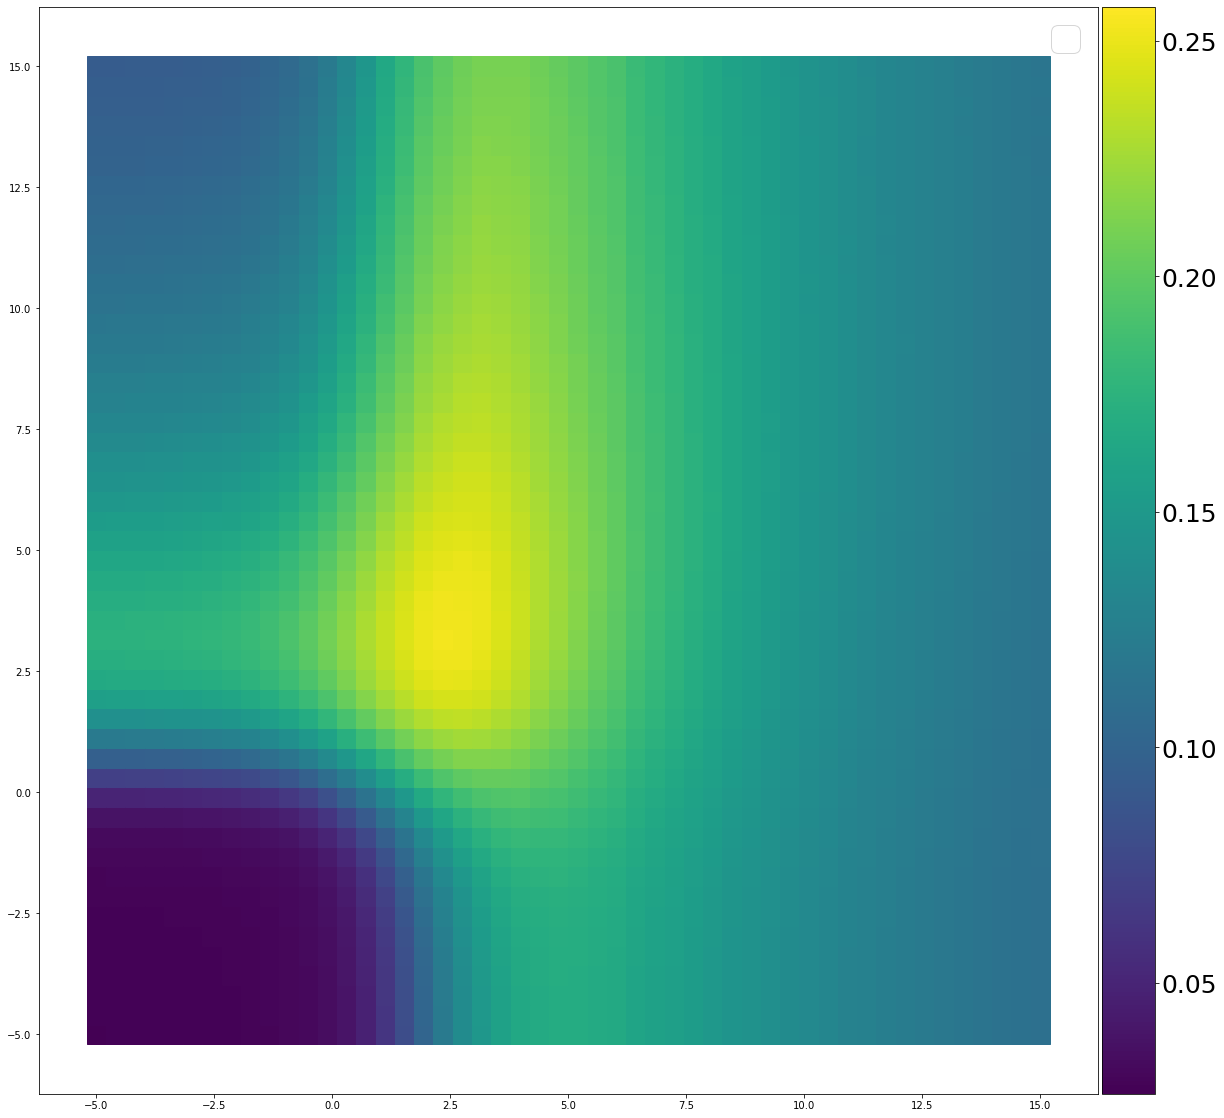

In [12]:

vd = {k: list(grad_df[k].unique()) for k in param_classes}
keys, values = list(zip(*vd.items()))
variants = list((itertools.product(*values)))

sideX = 1
sideY = 1
fig, axes = plt.subplots(sideY, sideX, figsize=(20 * sideX, 20 * sideY))

axes = onp.array(axes)


all_c = grad_df.returns
mapper = cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=all_c.min(), vmax=all_c.max()), cmap='viridis')

return_map = {}

for variant, ax in zip(variants, axes.flatten()):
    f = True
    for k, v in zip(keys, variant):
        f = f & (grad_df[k] == v) 
    df_ = grad_df[f].reset_index()
    
    if len(df_) == 0:
        continue

    # mean over seeds
    df = df_.groupby(['init_eta0', 'init_eta1']).mean().reset_index()

    half_w = (df.init_eta0.max() - df.init_eta0.min()) / (len(df.init_eta0.unique()) - 1) * 0.5
    half_h = (df.init_eta1.max() - df.init_eta1.min()) / (len(df.init_eta1.unique()) - 1) * 0.5

    for x, eta0, eta1 in df[['returns', 'init_eta0', 'init_eta1']].to_numpy():
        xs = [eta0-half_w, eta0+half_w, eta0+half_w, eta0-half_w]
        ys = [eta1-half_h, eta1-half_h, eta1+half_h, eta1+half_h]
        ax.fill(xs, ys, color=mapper.to_rgba(x), zorder=0)
        return_map[(eta0, eta1)] = x

ax.legend(fontsize=36).set_zorder(12)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(mapper, cax=cax)
cbar.ax.tick_params(labelsize=25)
cbar.ax.get_yaxis().labelpad = 15
# cbar.set_label('Entropy in the last episode', rotation=270, fontsize=20)
fig.subplots_adjust(wspace=0.1)

# Dice vs Naive vs Sampling Corrected Trajectory Plot

In [13]:
experiment_dirs = [
    '~/ray_results/on_policy_bandits:learn_lr_schedule:lt_len_30:noise_2:no_fd:lr_1em2:trajectories',
    '~/ray_results/on_policy_bandits:learn_lr_schedule:lt_len_30:noise_2:lr_1em2:trajectories:fd',

]

grad_dfs = []

param_classes = [
    'inner_loss',
    'update_with_fd',
    'meta_discount',
    'truncation_length',
]

for d in experiment_dirs:
    for path in glob.glob(os.path.join(d, '**/params.json')):
        with open(path, 'r') as f:
            params = pd.json_normalize(json.load(f))
        eta_init = params['initial_eta'].item()
        for rpath in glob.glob(os.path.join(os.path.dirname(path), '**/*.csv')):
            if params['inner_loss'].item() == 'no_is' and params['meta_discount'].item() == 0.0:
                continue
            df = pd.read_csv(rpath)
            df['init_eta0'] = eta_init[0]
            df['init_eta1'] = eta_init[1]
            df['seed'] = params['seed'].item()
            for c in param_classes:
                if params[c].item() is None:
                    df[c] = 'deadbeef'
                else:
                    df[c] = params[c].item()
            grad_dfs.append(df)




In [14]:
experiment_dirs = [
    '~/ray_results/on_policy_bandits:learn_lr_schedule:lt_len_30:noise_2:lr_5em2:trajectories:naive_only',
]

param_classes = [
    'inner_loss',
    'update_with_fd',
    'meta_discount',
    'truncation_length',
]

for d in experiment_dirs:
    for path in glob.glob(os.path.join(d, '**/params.json')):
        with open(path, 'r') as f:
            params = pd.json_normalize(json.load(f))
        eta_init = params['initial_eta'].item()
        for rpath in glob.glob(os.path.join(os.path.dirname(path), '**/*.csv')):
            df = pd.read_csv(rpath)
            df['init_eta0'] = eta_init[0]
            df['init_eta1'] = eta_init[1]
            df['seed'] = params['seed'].item()
            for c in param_classes:
                if params[c].item() is None:
                    df[c] = 'deadbeef'
                else:
                    df[c] = params[c].item()
            grad_dfs.append(df)


In [15]:
DF = pd.concat(grad_dfs)

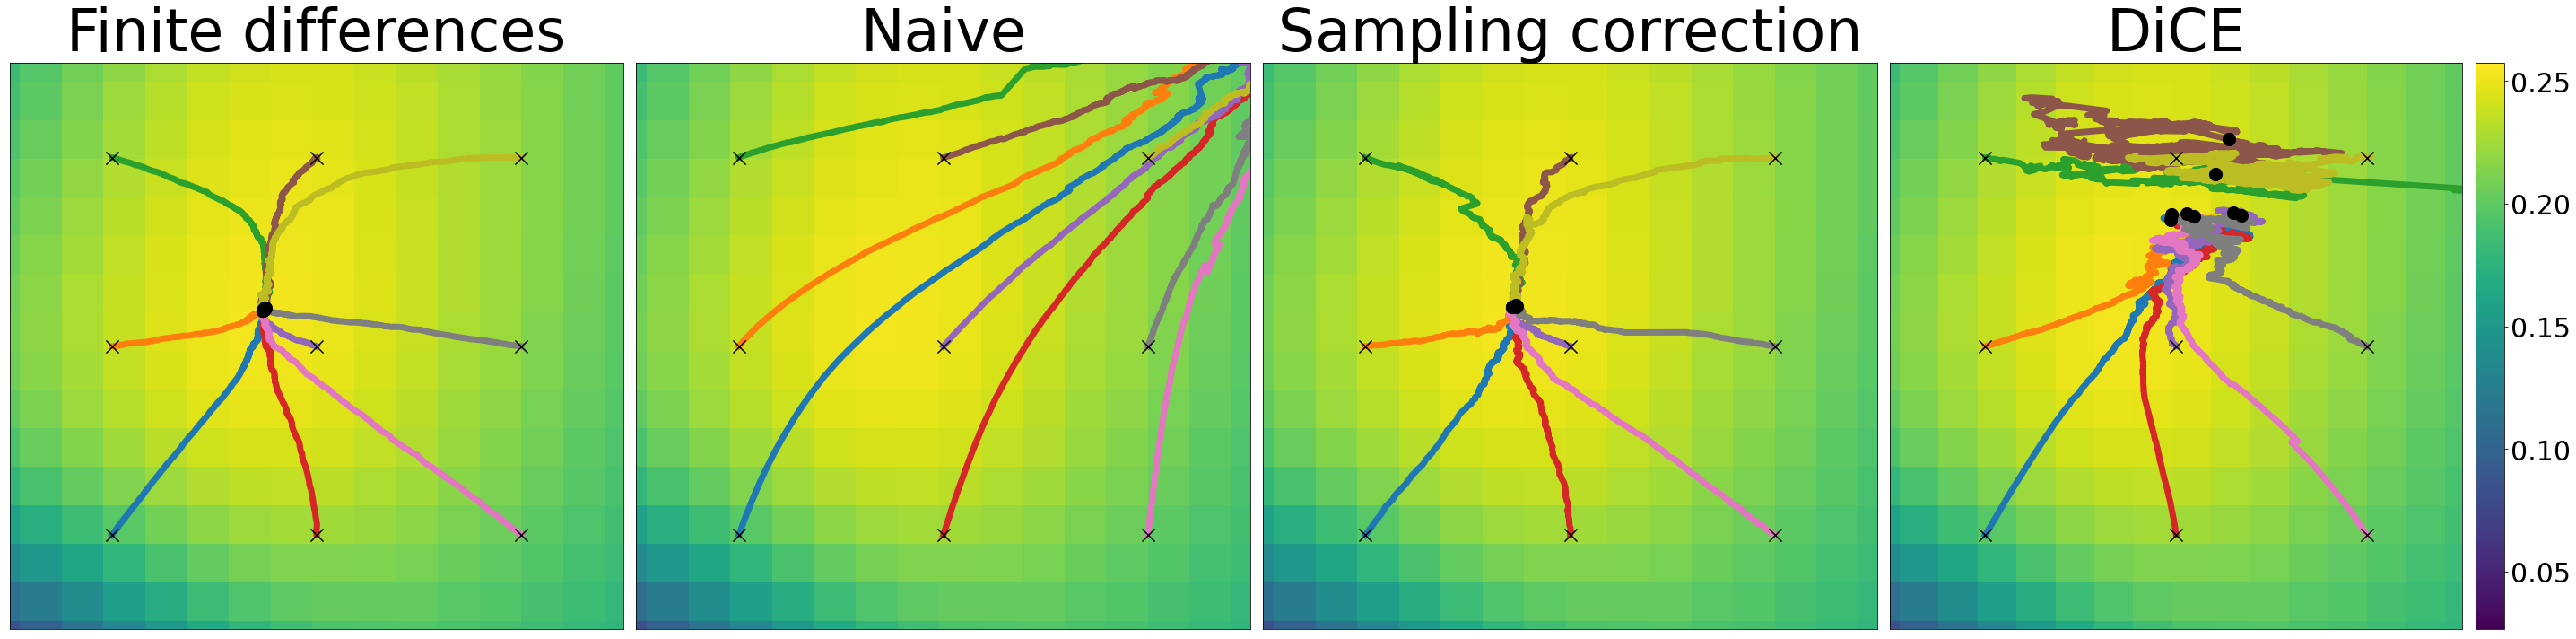

In [19]:

vd = {k: list(sorted(DF[k].unique())) for k in param_classes}
keys, values = list(zip(*vd.items()))
variant_to_title = {
    ('no_is', True, 1.0, 30): 'Finite differences',
    ('no_is', False, 0.0, 30): 'Naive',
    ('no_is', False, 1.0, 30): 'Sampling correction',
    ('dice', False, 0.0, 30): 'DiCE',
    # ('dice', False, 1.0, 30): 'DiCE + sampling correction',
}

sideX = 4
sideY = 1
fig, axes = plt.subplots(sideY, sideX, figsize=(10 * sideX, 10 * sideY), sharex=True, sharey=True)
axes = onp.array(axes)

xlim = (0.0, 6.0)
ylim = (0.0, 6.0)
subsample = 100

rm = return_map
min_eta0 = onp.array(list(rm.keys()))[:, 0].min()
max_eta0 = onp.array(list(rm.keys()))[:, 0].max()
min_eta1 = onp.array(list(rm.keys()))[:, 1].min()
max_eta1 = onp.array(list(rm.keys()))[:, 1].max()
half_w = (max_eta0 - min_eta0) / (len(onp.unique(onp.array(list(rm.keys()))[:, 0])) - 1) * 0.5
half_h = (max_eta1 - min_eta1) / (len(onp.unique(onp.array(list(rm.keys()))[:, 1])) - 1) * 0.5

for (variant, title), ax in zip(variant_to_title.items(), axes.flatten()):
    f = True
    for k, v in zip(keys, variant):
        f = f & (DF[k] == v) 
    df = DF[f].reset_index()
    
    if len(df) == 0:
        continue
    
    unique_eta_inits = df.groupby(['init_eta0', 'init_eta1']
        ).count().reset_index()[['init_eta0', 'init_eta1']].to_numpy()

    for eta0, eta1 in unique_eta_inits:
        df_ = df[(df.init_eta0 == eta0) & (df.init_eta1 == eta1)]
        ax.plot(*df_[['eta0', 'eta1']].to_numpy()[::subsample].T, linewidth=7)
        ax.scatter(*df_[['eta0', 'eta1']].to_numpy().T[:, -1], s=200, marker='o', c='black', zorder=100)
        ax.scatter(eta0, eta1, s=200, marker='x', c='black', zorder=100)

    ax.set_title(title, fontsize=65)
    ax.set_xticks([])
    ax.set_yticks([])

    for (eta0, eta1), x in rm.items():
        if eta0 + half_w < xlim[0] or eta0 - half_w > xlim[1] or eta1 + half_h < ylim[0] or eta1 - half_h > ylim[1]:
            continue
        xs = [eta0-half_w, eta0+half_w, eta0+half_w, eta0-half_w]
        ys = [eta1-half_h, eta1-half_h, eta1+half_h, eta1+half_h]
        ax.fill(xs, ys, color=mapper.to_rgba(x), zorder=0)

    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)

# ax.legend(fontsize=20).set_zorder(12)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
cbar = fig.colorbar(mapper, cax=cax)
cbar.ax.tick_params(labelsize=30)
cbar.ax.get_yaxis().labelpad = 15
plt.tight_layout()
# cbar.set_label('Entropy in the last episode', rotation=270, fontsize=20)
plt.savefig('bandit_learning_trajectories_4_panels.pdf', format='pdf')

In [490]:
DF.init_eta0.unique()

array([3., 5., 1.])

# Dice vs Naive vs Sampling Corrected Learning Curves

In [ ]:
experiment_dirs = [
    '~/ray_results/on_policy_bandits:learn_lr_schedule:lt_len_30:noise_2:lr_1em2:learning_curves:fd',
    '~/ray_results/on_policy_bandits:learn_lr_schedule:lt_len_30:noise_2:no_fd:lr_1em2:learning_curves',
]

grad_dfs = []

param_classes = [
    'inner_loss',
    'update_with_fd',
    'meta_discount',
    'truncation_length',
]

for d in experiment_dirs:
    for path in glob.glob(os.path.join(d, '**/params.json')):
        with open(path, 'r') as f:
            params = pd.json_normalize(json.load(f))
        eta_init = params['initial_eta'].item()
        for rpath in glob.glob(os.path.join(os.path.dirname(path), '**/*.csv')):
            df = pd.read_csv(rpath)
            df['init_eta0'] = eta_init[0]
            df['init_eta1'] = eta_init[1]
            df['seed'] = params['seed'].item()
            for c in param_classes:
                if params[c].item() is None:
                    df[c] = 'deadbeef'
                else:
                    df[c] = params[c].item()
            grad_dfs.append(df)

# DF = DF[DF.iteration < 40000]


In [ ]:
DF = pd.concat(grad_dfs)

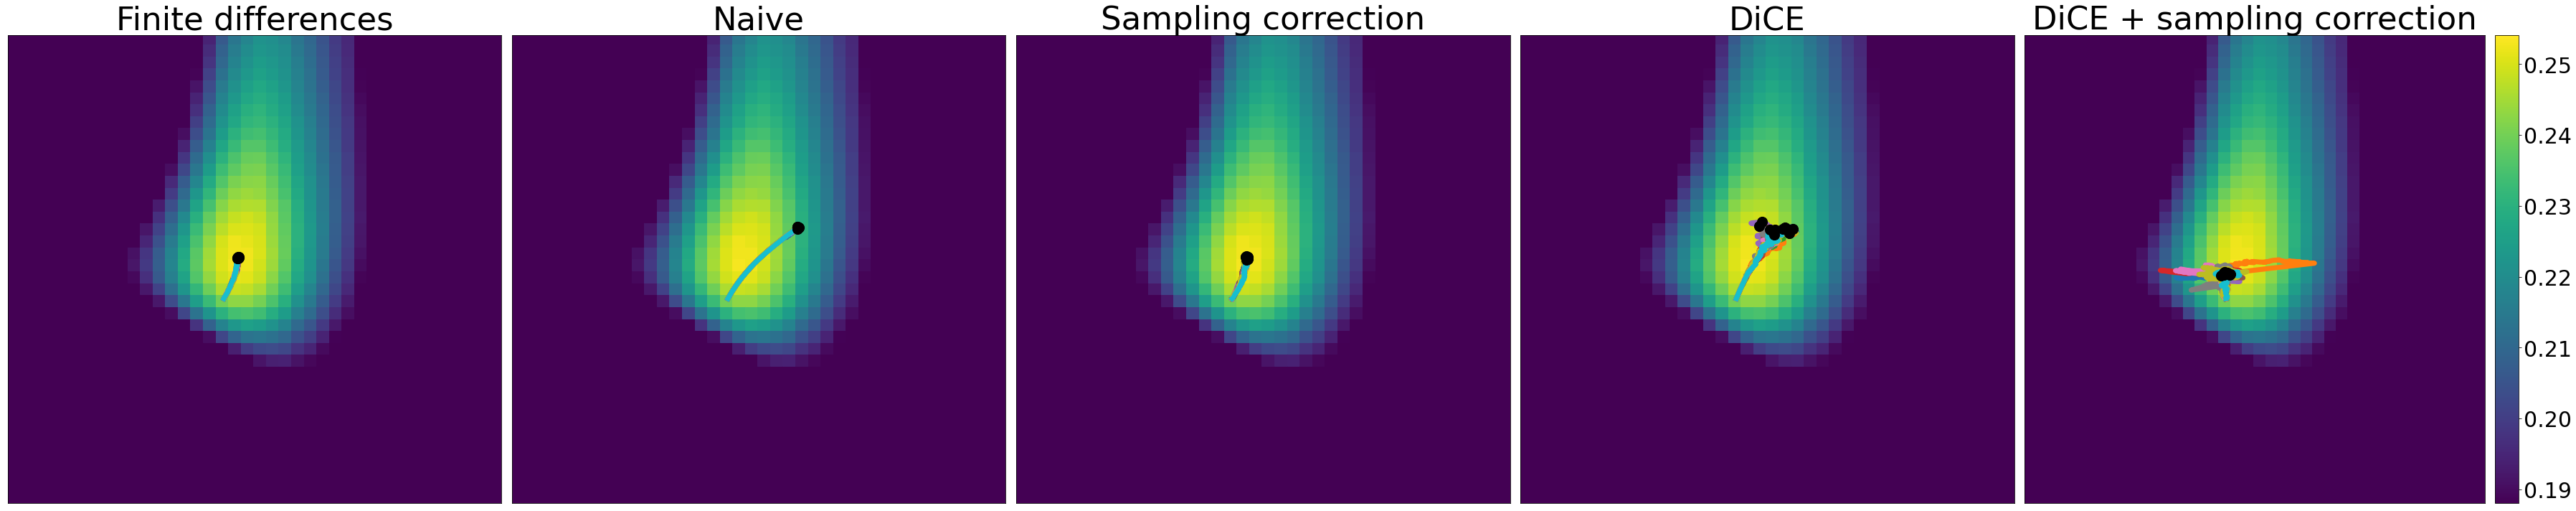

In [ ]:

vd = {k: list(sorted(DF[k].unique())) for k in param_classes}
keys, values = list(zip(*vd.items()))
variant_to_title = {
    ('no_is', True, 1.0, 30): 'Finite differences',
    ('no_is', False, 0.0, 30): 'Naive',
    ('no_is', False, 1.0, 30): 'Sampling correction',
    ('dice', False, 0.0, 30): 'DiCE',
    ('dice', False, 1.0, 30): 'DiCE + sampling correction',
}

sideX = 5
sideY = 1
fig, axes = plt.subplots(sideY, sideX, figsize=(10 * sideX, 10 * sideY), sharex=True, sharey=True)
axes = onp.array(axes)

xlim = (-5.0, 11.0)
ylim = (-5.0, 11.0)
subsample = 100

rm = return_map
min_eta0 = onp.array(list(rm.keys()))[:, 0].min()
max_eta0 = onp.array(list(rm.keys()))[:, 0].max()
min_eta1 = onp.array(list(rm.keys()))[:, 1].min()
max_eta1 = onp.array(list(rm.keys()))[:, 1].max()
half_w = (max_eta0 - min_eta0) / (len(onp.unique(onp.array(list(rm.keys()))[:, 0])) - 1) * 0.5
half_h = (max_eta1 - min_eta1) / (len(onp.unique(onp.array(list(rm.keys()))[:, 1])) - 1) * 0.5

for (variant, title), ax in zip(variant_to_title.items(), axes.flatten()):
    f = True
    for k, v in zip(keys, variant):
        f = f & (DF[k] == v) 
    df = DF[f].reset_index()
    
    if len(df) == 0:
        continue
    
#     unique_eta_inits = df.groupby(['init_eta0', 'init_eta1']
#         ).count().reset_index()[['init_eta0', 'init_eta1']].to_numpy()

    seeds = df.groupby(['seed']).count().reset_index()[['seed']].to_numpy()
    for seed in seeds:
        df_ = df[(df.seed == seed[0])]
        ax.plot(*df_[['eta0', 'eta1']].to_numpy()[::subsample].T, linewidth=7)
        ax.scatter(*df_[['eta0', 'eta1']].to_numpy().T[:, -1], s=200, marker='o', c='black', zorder=100)
        ax.scatter(eta0, eta1, s=200, marker='x', c='black', zorder=100)

    ax.set_title(title, fontsize=45)
    ax.set_xticks([])
    ax.set_yticks([])

    for (eta0, eta1), x in rm.items():
        if eta0 < xlim[0] or eta0 > xlim[1] or eta1 < ylim[0] or eta1 > ylim[1]:
            continue
        xs = [eta0-half_w, eta0+half_w, eta0+half_w, eta0-half_w]
        ys = [eta1-half_h, eta1-half_h, eta1+half_h, eta1+half_h]
        ax.fill(xs, ys, color=mapper.to_rgba(x), zorder=0)

    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)

# ax.legend(fontsize=20).set_zorder(12)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
cbar = fig.colorbar(mapper, cax=cax)
cbar.ax.tick_params(labelsize=30)
cbar.ax.get_yaxis().labelpad = 15
plt.tight_layout()
# cbar.set_label('Entropy in the last episode', rotation=270, fontsize=20)
# plt.savefig('bandit_learning_trajectories.pdf', format='pdf')

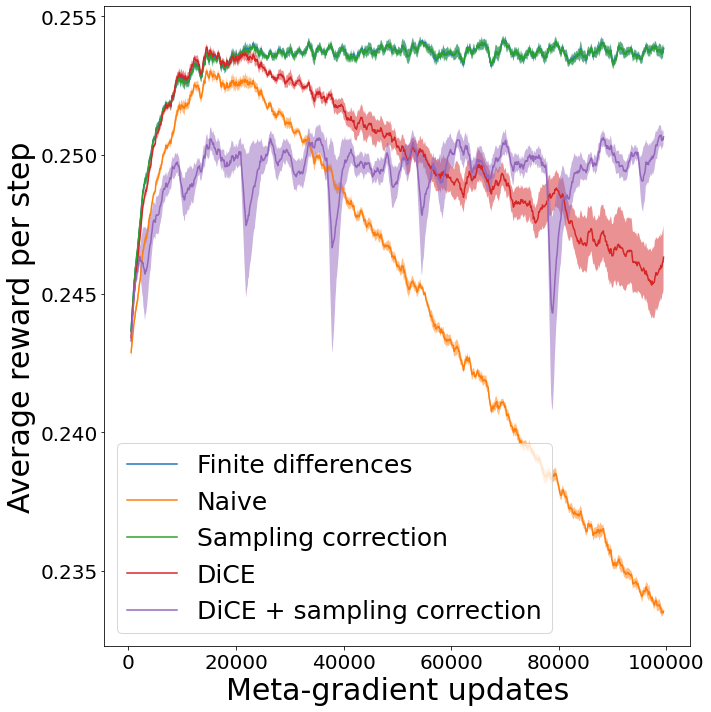

In [ ]:
TICK_SIZE = 20
AXIS_LABEL_SIZE = 30

keys = ['inner_loss', 'update_with_fd', 'meta_discount', 'truncation_length']
v2l = {
    ('no_is', True, 1.0, 30): 'Finite differences',
    ('no_is', False, 0.0, 30): 'Naive',
    ('no_is', False, 1.0, 30): 'Sampling correction',
    ('dice', False, 0.0, 30): 'DiCE',
    ('dice', False, 1.0, 30): 'DiCE + sampling correction',
}
sideX = 1
sideY = 1
fig, axes = plt.subplots(sideY, sideX, figsize=(10 * sideX, 10 * sideY), sharey=True)
axes = onp.array(axes)
window = 1000

ax = axes.flatten()[0]
# ax.set_title(f'Lifetime length 10, Truncation length {trunc_len}', fontsize=30)
for i, variant in enumerate(v2l.keys()):
    f = True
    for k, v in zip(keys, variant):
        f = f & (DF[k] == v) 
    df = DF[f].reset_index()
    
    if len(df) == 0:
        continue
    
    mean_divisor = df.groupby(['seed']).count().reset_index()[['seed']].to_numpy()

    data = df
    
    smoothed = data.groupby(['seed']).rolling(window).mean().groupby('iteration')
    y = smoothed.mean()['returns'].to_numpy()[::100]
    stderr = smoothed.std()['returns'].fillna(0.).to_numpy()[::100] / onp.sqrt(len(df.seed.unique()))
    x = smoothed.min().index[::100]
    out = pd.DataFrame({'x': x, 'y': y})
    out.reset_index(inplace=True, drop=True)
    ax.plot(out.x, out.y, label=f"{v2l[variant]}")
    ax.fill_between(out.x, out.y-stderr, out.y+stderr, alpha=0.5)

    ax.tick_params(axis='both', which='major', labelsize=TICK_SIZE)
ax.legend(fontsize=LEGEND_FONTSIZE)
_=ax.set_xlabel('Meta-gradient updates', fontsize=AXIS_LABEL_SIZE)
_=ax.set_ylabel('Average reward per step', fontsize=AXIS_LABEL_SIZE)
plt.tight_layout()
plt.savefig('bandit_learning_curves_stderr.pdf')





# Compare truncation lengths

In [ ]:
experiment_dirs = [   
    '~/ray_results/on_policy_bandits:learn_lr_schedule:lt_len_30:noise_2:eta_init_22:lr_0005:500k_steps:trunc_in_23_30:sweep_elambda',
    '~/ray_results/on_policy_bandits:learn_lr_schedule:lt_len_30:noise_2:eta_init_22:lr_005:500k_steps:trunc_in_2_9:sweep_elambda',
]

grad_dfs = []

param_classes = [
    'e_maml_lambda',
    'truncation_length',
]

for d in experiment_dirs:
    for path in glob.glob(os.path.join(d, '**/params.json')):
        with open(path, 'r') as f:
            params = pd.json_normalize(json.load(f))
        eta_init = params['initial_eta'].item()
        for rpath in glob.glob(os.path.join(os.path.dirname(path), '**/*.csv')):
            df = pd.read_csv(rpath)
            df['init_eta0'] = eta_init[0]
            df['init_eta1'] = eta_init[1]
            df['seed'] = params['seed'].item()
            for c in param_classes:
                if params[c].item() is None:
                    df[c] = 'deadbeef'
                else:
                    df[c] = params[c].item()
            grad_dfs.append(df)

DF = pd.concat(grad_dfs)
vd = {k: list(sorted(DF[k].unique())) for k in param_classes}
keys, values = list(zip(*vd.items()))
variants = list((itertools.product(*values)))

In [ ]:
len(DF.seed.unique())

5

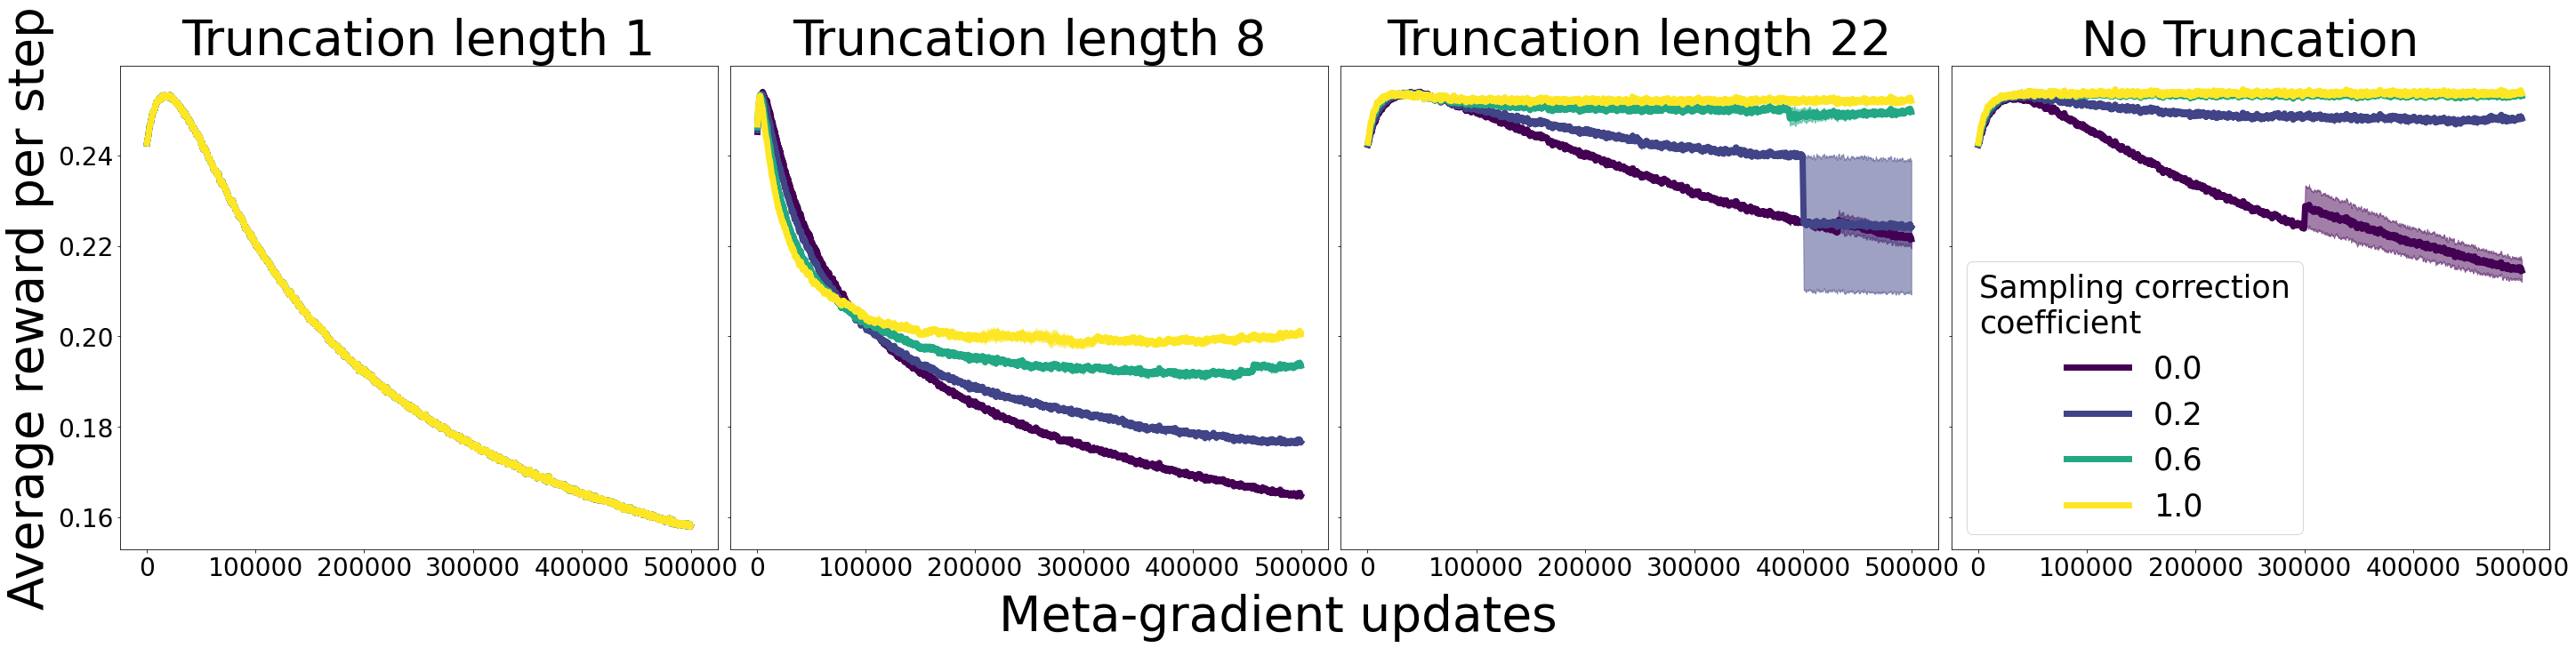

In [ ]:
v2l = {
    (0.0, 2): "0.0",
    (0.0, 9): "0.0",
    (0.0, 16): "0.0",
    (0.0, 23): "0.0",
    (0.0, 30): "0.0",
    (2.0, 2): "0.2",
    (2.0, 9): "0.2",
    (2.0, 16): "0.2",
    (2.0, 23): "0.2",
    (2.0, 30): "0.2",
    (4.0, 2): "0.4",
    (4.0, 9): "0.4",
    (4.0, 16): "0.4",
    (4.0, 23): "0.4",
    (4.0, 30): "0.4",
    (6.0, 2): "0.6",
    (6.0, 9): "0.6",
    (6.0, 16): "0.6",
    (6.0, 23): "0.6",
    (6.0, 30): "0.6",
    (8.0, 2): "0.8",
    (8.0, 9): "0.8",
    (8.0, 16): "0.8",
    (8.0, 23): "0.8",
    (8.0, 30): "0.8",
    (10.0, 2): "1.0",
    (10.0, 9): "1.0",
    (10.0, 16): "1.0",
    (10.0, 23): "1.0",
    (10.0, 30): "1.0",
}


truncation_lengths = [2, 9, 23, 30]
titles = ['Truncation length 1', 'Truncation length 8', 'Truncation length 22', 'No Truncation']
sideX = 4
sideY = 1
fig, axes = plt.subplots(sideY, sideX, figsize=(10 * sideX, 10 * sideY), sharey=True)
axes = onp.array(axes)
window = 1000

ax = axes.flatten()[0]
# ax.set_title(f'Lifetime length 10, Truncation length {trunc_len}', fontsize=30)
for ax, trunc_len, title in zip(axes.flatten(), truncation_lengths, titles):
    for i, variant in enumerate(v2l.keys()):
        if variant[1] != trunc_len:
            continue
        f = True
        for k, v in zip(keys, variant):
            f = f & (DF[k] == v) 
        df = DF[f].reset_index()

        if len(df) == 0:
            continue

#     #     df_ = df.groupby(['iteration']).mean().reset_index()
#         unique_eta_inits = df.groupby(['init_eta0', 'init_eta1']
#             ).count().reset_index()[['init_eta0', 'init_eta1']].to_numpy()

# #         data = df[df.iteration < 50000]
#         data = df

#         smoothed = data.groupby(['init_eta0', 'init_eta1']).rolling(window).mean().groupby('iteration')
#         y = smoothed.mean()['returns'].to_numpy()
#         stderr = smoothed.std()['returns'].fillna(0.).to_numpy() / onp.sqrt(len(unique_eta_inits))
#         x = smoothed.min().index
#         out = pd.DataFrame({'x': x, 'y': y})
#         out.reset_index(inplace=True, drop=True)
#         ax.plot(out.x, out.y, label=f"Meta-discount: {variant[2]}")
#     #     ax.fill_between(out.x, out.y-stderr, out.y+stderr, alpha=0.5)

#         ax.tick_params(axis='both', which='major', labelsize=30)
        
        mean_divisor = df.groupby(['seed']).count().reset_index()[['seed']].to_numpy()

        data = df

        smoothed = data.groupby(['seed']).rolling(window).mean().groupby('iteration')
        y = smoothed.mean()['returns'].to_numpy()[::100]
        stderr = smoothed.std()['returns'].fillna(0.).to_numpy()[::100] / onp.sqrt(len(df.seed.unique()))
        x = smoothed.min().index[::100]
        out = pd.DataFrame({'x': x, 'y': y})
        out.reset_index(inplace=True, drop=True)
        ax.plot(
            out.x, out.y,
            label=f"{v2l[variant]}",
            color=plt.get_cmap('viridis')(df.e_maml_lambda.unique().item() / DF.e_maml_lambda.unique().max()),
            linewidth=7.0
        )
        ax.fill_between(
            out.x, out.y-stderr, out.y+stderr,
            alpha=0.5,
            color=plt.get_cmap('viridis')(df.e_maml_lambda.unique().item() / DF.e_maml_lambda.unique().max())
        )
        ax.tick_params(axis='both', which='major', labelsize=TICK_SIZE - 2)

    ax.set_title(f"{title}", fontsize=AXIS_LABEL_SIZE)
ax.legend(
    title="Sampling correction\ncoefficient",
    fontsize=LEGEND_FONTSIZE + 10,
    title_fontsize=LEGEND_TITLE_FONTSIZE,
)

# _=ax.set_xlabel('Meta-gradient updates', fontsize=AXIS_LABEL_SIZE)
# _=ax.set_ylabel('Average reward per step', fontsize=AXIS_LABEL_SIZE)
fig.supxlabel('Meta-gradient updates', fontsize=AXIS_LABEL_SIZE)
# fig.supylabel('Average reward per step', fontsize=AXIS_LABEL_SIZE)
_=axes.flatten()[0].set_ylabel('Average reward per step', fontsize=AXIS_LABEL_SIZE)

plt.tight_layout()
plt.savefig('truncated_learning_curves_stderr.pdf')


# Compare truncation lengths with adam

In [3]:
experiment_dirs = [   
    '~/ray_results/on_policy_bandits:learn_lr_schedule:lt_len_30:noise_2:eta_init_22:lr_0001:200k_steps:sweep_trunc:sweep_elambda:adam_lr_1em3',
]

grad_dfs = []

param_classes = [
    'e_maml_lambda',
    'truncation_length',
]

for d in experiment_dirs:
    for path in glob.glob(os.path.join(d, '**/params.json')):
        with open(path, 'r') as f:
            params = pd.json_normalize(json.load(f))
        eta_init = params['initial_eta'].item()
        for rpath in glob.glob(os.path.join(os.path.dirname(path), '**/*.csv')):
            df = pd.read_csv(rpath)
            df['init_eta0'] = eta_init[0]
            df['init_eta1'] = eta_init[1]
            df['seed'] = params['seed'].item()
            for c in param_classes:
                if params[c].item() is None:
                    df[c] = 'deadbeef'
                else:
                    df[c] = params[c].item()
            grad_dfs.append(df)

DF = pd.concat(grad_dfs)
vd = {k: list(sorted(DF[k].unique())) for k in param_classes}
keys, values = list(zip(*vd.items()))
variants = list((itertools.product(*values)))

## Two rows

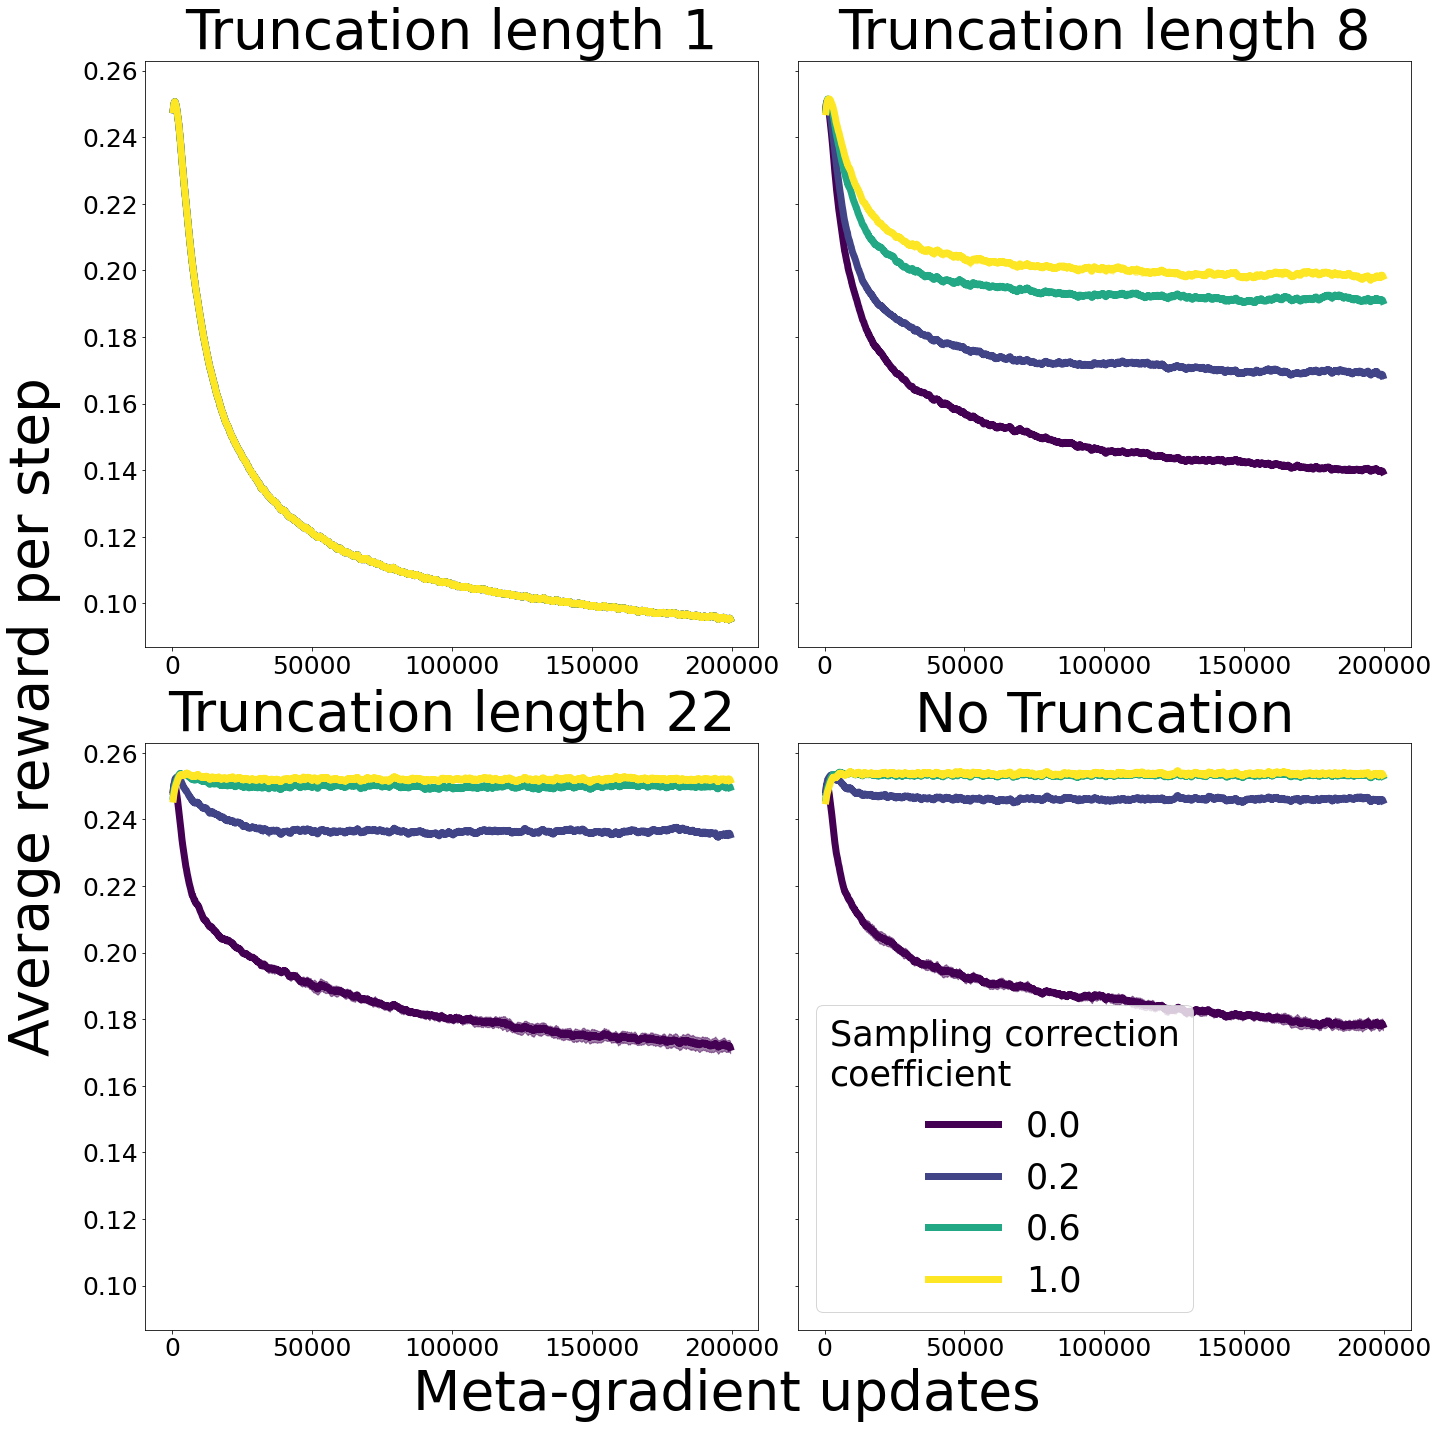

In [ ]:
v2l = {
    (0.0, 2): "0.0",
    (0.0, 9): "0.0",
    (0.0, 16): "0.0",
    (0.0, 23): "0.0",
    (0.0, 30): "0.0",
    (2.0, 2): "0.2",
    (2.0, 9): "0.2",
    (2.0, 16): "0.2",
    (2.0, 23): "0.2",
    (2.0, 30): "0.2",
    (4.0, 2): "0.4",
    (4.0, 9): "0.4",
    (4.0, 16): "0.4",
    (4.0, 23): "0.4",
    (4.0, 30): "0.4",
    (6.0, 2): "0.6",
    (6.0, 9): "0.6",
    (6.0, 16): "0.6",
    (6.0, 23): "0.6",
    (6.0, 30): "0.6",
    (8.0, 2): "0.8",
    (8.0, 9): "0.8",
    (8.0, 16): "0.8",
    (8.0, 23): "0.8",
    (8.0, 30): "0.8",
    (10.0, 2): "1.0",
    (10.0, 9): "1.0",
    (10.0, 16): "1.0",
    (10.0, 23): "1.0",
    (10.0, 30): "1.0",
}


truncation_lengths = [2, 9, 23, 30]
titles = ['Truncation length 1', 'Truncation length 8', 'Truncation length 22', 'No Truncation']
sideX = 2
sideY = 2
fig, axes = plt.subplots(sideY, sideX, figsize=(10 * sideX, 10 * sideY), sharey=True)
axes = onp.array(axes)
window = 1000

ax = axes.flatten()[0]
# ax.set_title(f'Lifetime length 10, Truncation length {trunc_len}', fontsize=30)
for ax, trunc_len, title in zip(axes.flatten(), truncation_lengths, titles):
    for i, variant in enumerate(v2l.keys()):
        if variant[1] != trunc_len:
            continue
        f = True
        for k, v in zip(keys, variant):
            f = f & (DF[k] == v) 
        df = DF[f].reset_index()

        if len(df) == 0:
            continue

#     #     df_ = df.groupby(['iteration']).mean().reset_index()
#         unique_eta_inits = df.groupby(['init_eta0', 'init_eta1']
#             ).count().reset_index()[['init_eta0', 'init_eta1']].to_numpy()

# #         data = df[df.iteration < 50000]
#         data = df

#         smoothed = data.groupby(['init_eta0', 'init_eta1']).rolling(window).mean().groupby('iteration')
#         y = smoothed.mean()['returns'].to_numpy()
#         stderr = smoothed.std()['returns'].fillna(0.).to_numpy() / onp.sqrt(len(unique_eta_inits))
#         x = smoothed.min().index
#         out = pd.DataFrame({'x': x, 'y': y})
#         out.reset_index(inplace=True, drop=True)
#         ax.plot(out.x, out.y, label=f"Meta-discount: {variant[2]}")
#     #     ax.fill_between(out.x, out.y-stderr, out.y+stderr, alpha=0.5)

#         ax.tick_params(axis='both', which='major', labelsize=30)
        
        mean_divisor = df.groupby(['seed']).count().reset_index()[['seed']].to_numpy()

        data = df

        smoothed = data.groupby(['seed']).rolling(window).mean().groupby('iteration')
        y = smoothed.mean()['returns'].to_numpy()[::100]
        stderr = smoothed.std()['returns'].fillna(0.).to_numpy()[::100] / onp.sqrt(len(df.seed.unique()))
        x = smoothed.min().index[::100]
        out = pd.DataFrame({'x': x, 'y': y})
        out.reset_index(inplace=True, drop=True)
        ax.plot(
            out.x, out.y,
            label=f"{v2l[variant]}",
            color=plt.get_cmap('viridis')(df.e_maml_lambda.unique().item() / DF.e_maml_lambda.unique().max()),
            linewidth=7.0
        )
        ax.fill_between(
            out.x, out.y-stderr, out.y+stderr,
            alpha=0.5,
            color=plt.get_cmap('viridis')(df.e_maml_lambda.unique().item() / DF.e_maml_lambda.unique().max())
        )
        ax.tick_params(axis='both', which='major', labelsize=TICK_SIZE - 5)

    ax.set_title(f"{title}", fontsize=AXIS_LABEL_SIZE)
ax.legend(
    title="Sampling correction\ncoefficient",
    fontsize=LEGEND_FONTSIZE + 10,
    title_fontsize=LEGEND_TITLE_FONTSIZE,
)


fig.supxlabel('Meta-gradient updates', fontsize=AXIS_LABEL_SIZE)
fig.supylabel('Average reward per step', fontsize=AXIS_LABEL_SIZE, x=0.0)
# _=axes.flatten()[0].set_ylabel('Average reward per step', fontsize=AXIS_LABEL_SIZE)
plt.tight_layout()
plt.savefig('truncated_learning_curves_adam_stderr_two_rows.pdf')


# Bias Variance Plot

In [7]:
LEGEND_TITLE_FONTSIZE = 35
LEGEND_FONTSIZE = 25
AXIS_LABEL_SIZE = 55
TICK_SIZE = 30

In [3]:
experiment_dirs = [
    '~/ray_results/on_policy_bandits:learn_lr_schedule:lt_len_80:noise_2:mg:range_05_25:index_cutoff_10',
    '~/ray_results/on_policy_bandits:learn_lr_schedule:lt_len_80:noise_2:mg:range_05_25:index_cutoff_10:ml_0to8',
    '~/ray_results/on_policy_bandits:learn_lr_schedule:lt_len_80:noise_2:mg:range_05_25:index_cutoff_10:ml_0to10:truncated_estimators:1_seed',
]

grad_dfs = []

param_classes = [
    'inner_loss',
    'truncation_length',
    'meta_discount',
    'e_maml_lambda',
    'parallel_runs',
    'popsize',
]

for d in experiment_dirs:
    for path in glob.glob(os.path.join(d, '**/params.json')):
        with open(path, 'r') as f:
            params = pd.json_normalize(json.load(f))
        eta_init = params['initial_eta'].item()
        for rpath in glob.glob(os.path.join(os.path.dirname(path), '**/*.csv')):
            df = pd.read_csv(rpath)
            df['init_eta0'] = eta_init[0]
            df['init_eta1'] = eta_init[1]
            df['seed'] = params['seed'].item()
            for c in param_classes:
                if params[c].item() is None:
                    df[c] = 'deadbeef'
                else:
                    df[c] = params[c].item()
            grad_dfs.append(df)

DF = pd.concat(grad_dfs)


In [4]:
experiment_dirs = [
    '~/ray_results/on_policy_bandits:learn_lr_schedule:lt_len_80:noise_2:mg:range_05_25:index_cutoff_10:dice',
]

grad_dfs = []



for d in experiment_dirs:
    for path in glob.glob(os.path.join(d, '**/params.json')):
        with open(path, 'r') as f:
            params = pd.json_normalize(json.load(f))
        eta_init = params['initial_eta'].item()
        for rpath in glob.glob(os.path.join(os.path.dirname(path), '**/*.csv')):
            df = pd.read_csv(rpath)
            df['init_eta0'] = eta_init[0]
            df['init_eta1'] = eta_init[1]
            df['seed'] = params['seed'].item()
            for c in param_classes:
                if params[c].item() is None:
                    df[c] = 'deadbeef'
                else:
                    df[c] = params[c].item()
            grad_dfs.append(df)

D_DF = pd.concat(grad_dfs)


In [5]:
experiment_dirs = [
    '~/ray_results/on_policy_bandits:learn_lr_schedule:lt_len_80:noise_2:fd:range_05_25:index_cutoff_10:epsilon_001:more_samples',
]

grad_dfs = []

param_classes = [
    'inner_loss',
    'truncation_length',
    'meta_discount',
    'e_maml_lambda',
    'parallel_runs',
]

for d in experiment_dirs:
    for path in glob.glob(os.path.join(d, '**/params.json')):
        with open(path, 'r') as f:
            params = pd.json_normalize(json.load(f))
        eta_init = params['initial_eta'].item()
        for rpath in glob.glob(os.path.join(os.path.dirname(path), '**/*.csv')):
            df = pd.read_csv(rpath)
            df['init_eta0'] = eta_init[0]
            df['init_eta1'] = eta_init[1]
            df['seed'] = params['seed'].item()
            for c in param_classes:
                if params[c].item() is None:
                    df[c] = 'deadbeef'
                else:
                    df[c] = params[c].item()
            grad_dfs.append(df)

FD_DF = pd.concat(grad_dfs)


In [8]:
experiment_dirs = [
    '~/ray_results/on_policy_bandits:learn_lr_schedule:lt_len_80:noise_2:es:range_05_25:index_cutoff_10'
]

grad_dfs = []

param_classes = [
    'inner_loss',
    'truncation_length',
    'meta_discount',
    'e_maml_lambda',
    'parallel_runs',
    'popsize',
]


for d in experiment_dirs:
    for path in glob.glob(os.path.join(d, '**/params.json')):
        with open(path, 'r') as f:
            params = pd.json_normalize(json.load(f))
        eta_init = params['initial_eta'].item()
        for rpath in glob.glob(os.path.join(os.path.dirname(path), '**/*.csv')):
            df = pd.read_csv(rpath)
            df['init_eta0'] = eta_init[0]
            df['init_eta1'] = eta_init[1]
            df['seed'] = params['seed'].item()
            for c in param_classes:
                if params[c].item() is None:
                    df[c] = 'deadbeef'
                else:
                    df[c] = params[c].item()
            grad_dfs.append(df)

ES_DF = pd.concat(grad_dfs)


In [9]:
vd = {k: list(DF[k].unique()) for k in param_classes}
keys, values = list(zip(*vd.items()))
all_variants = list((itertools.product(*values)))



In [10]:
def combine(averages, variances, counts, size=None):
    """
    https://stats.stackexchange.com/questions/10441/how-to-calculate-the-variance-of-a-partition-of-variables
    Combine averages and variances to one single average and variance.

    # Arguments
        averages: List of averages for each part.
        variances: List of variances for each part.
        counts: List of number of elements in each part.
        size: Total number of elements in all of the parts.
    # Returns
        average: Average over all parts.
        variance: Variance over all parts.
    """
    average = onp.average(averages, weights=counts)

    # necessary for correct variance in case of multidimensional arrays
    if size is not None:
        counts = counts * size // onp.sum(counts, dtype='int')
    else:
        size = onp.sum(counts)

    squares = (counts - 1) * variances + counts * (averages - average)**2
    return average, onp.sum(squares) / (size - 1)

# Variance across inits 2

In [12]:
def boostrap_ci_across_init_bias(base_df, grad_df, repetitions):
    all_eta_inits = base_df.groupby(['init_eta0', 'init_eta1']
        ).count().reset_index()[['init_eta0', 'init_eta1']]
    bootstrap_sample_size = len(all_eta_inits)
    
    inner_memo = {}

    diffs = []
    variances = []
    for i in range(repetitions):
        if repetitions == 1:
            unique_eta_inits = all_eta_inits.to_numpy()
        else:
            unique_eta_inits = all_eta_inits.sample(n=bootstrap_sample_size, replace=True).to_numpy()
        
        mean_differences = []
        estimator_variances = []
        for eta0, eta1 in unique_eta_inits:
            if (eta0, eta1) in inner_memo:
                mean_difference, var0, var1 = inner_memo[(eta0, eta1)]
            else:
                grad_df_ = grad_df[(grad_df.init_eta0 == eta0) & (grad_df.init_eta1 == eta1)]
                if len(grad_df_) == 0:
                    continue
                pgg = grad_df_[['g0', 'g1']].to_numpy().mean(axis=0)
                fd_df_ = FD_DF[(FD_DF.init_eta0 == eta0) & (FD_DF.init_eta1 == eta1)]
                fdg = fd_df_[['eta_fd_g0', 'eta_fd_g1']].to_numpy().mean(axis=0)

                mean_difference = onp.mean(onp.square(fdg - pgg))
                pg0_mean = grad_df_['g0']
                pg0_var = grad_df_['g0_var']
                
                if 'popsize' in grad_df.columns:
                    parallel_runs = grad_df.parallel_runs.unique()[0] * grad_df.popsize.unique()[0]
                else:
                    parallel_runs = grad_df.parallel_runs.unique()[0]
                
                counts = onp.ones_like(pg0_var) * parallel_runs
                size = len(pg0_var) * parallel_runs
                _, var0 = combine(pg0_mean, pg0_var, counts, size)

                pg1_mean = grad_df_['g1']
                pg1_var = grad_df_['g1_var']
                counts = onp.ones_like(pg1_var) * parallel_runs
                size = len(pg1_var) * parallel_runs
                _, var1 = combine(pg1_mean, pg1_var, counts, size)
                inner_memo[(eta0, eta1)] = (mean_difference, var0, var1)

            mean_differences.append(mean_difference)
            estimator_variances.append(var0 + var1)
        diffs.append(onp.mean(mean_differences))
        variances.append(onp.mean(estimator_variances))
    item = {
        'mean_diff': onp.mean(diffs),
        'med_diff': onp.median(diffs),
        'std_diff': onp.std(diffs),
        'q1_diff': onp.percentile(diffs, 25),
        'q3_diff': onp.percentile(diffs, 75),
        'whislo_diff': onp.min(diffs),
        'whishi_diff': onp.max(diffs),
        
        'mean_var': onp.mean(variances),
        'med_var': onp.median(variances),
        'q1_var': onp.percentile(variances, 25),
        'q3_var': onp.percentile(variances, 75),
        'whislo_var': onp.min(variances),
        'whishi_var': onp.max(variances),
        'size': pg0_var.size,
        'shape': pg0_var.shape,
    }
    return item


In [13]:
memo = {}

In [14]:
memo.keys()

dict_keys([])

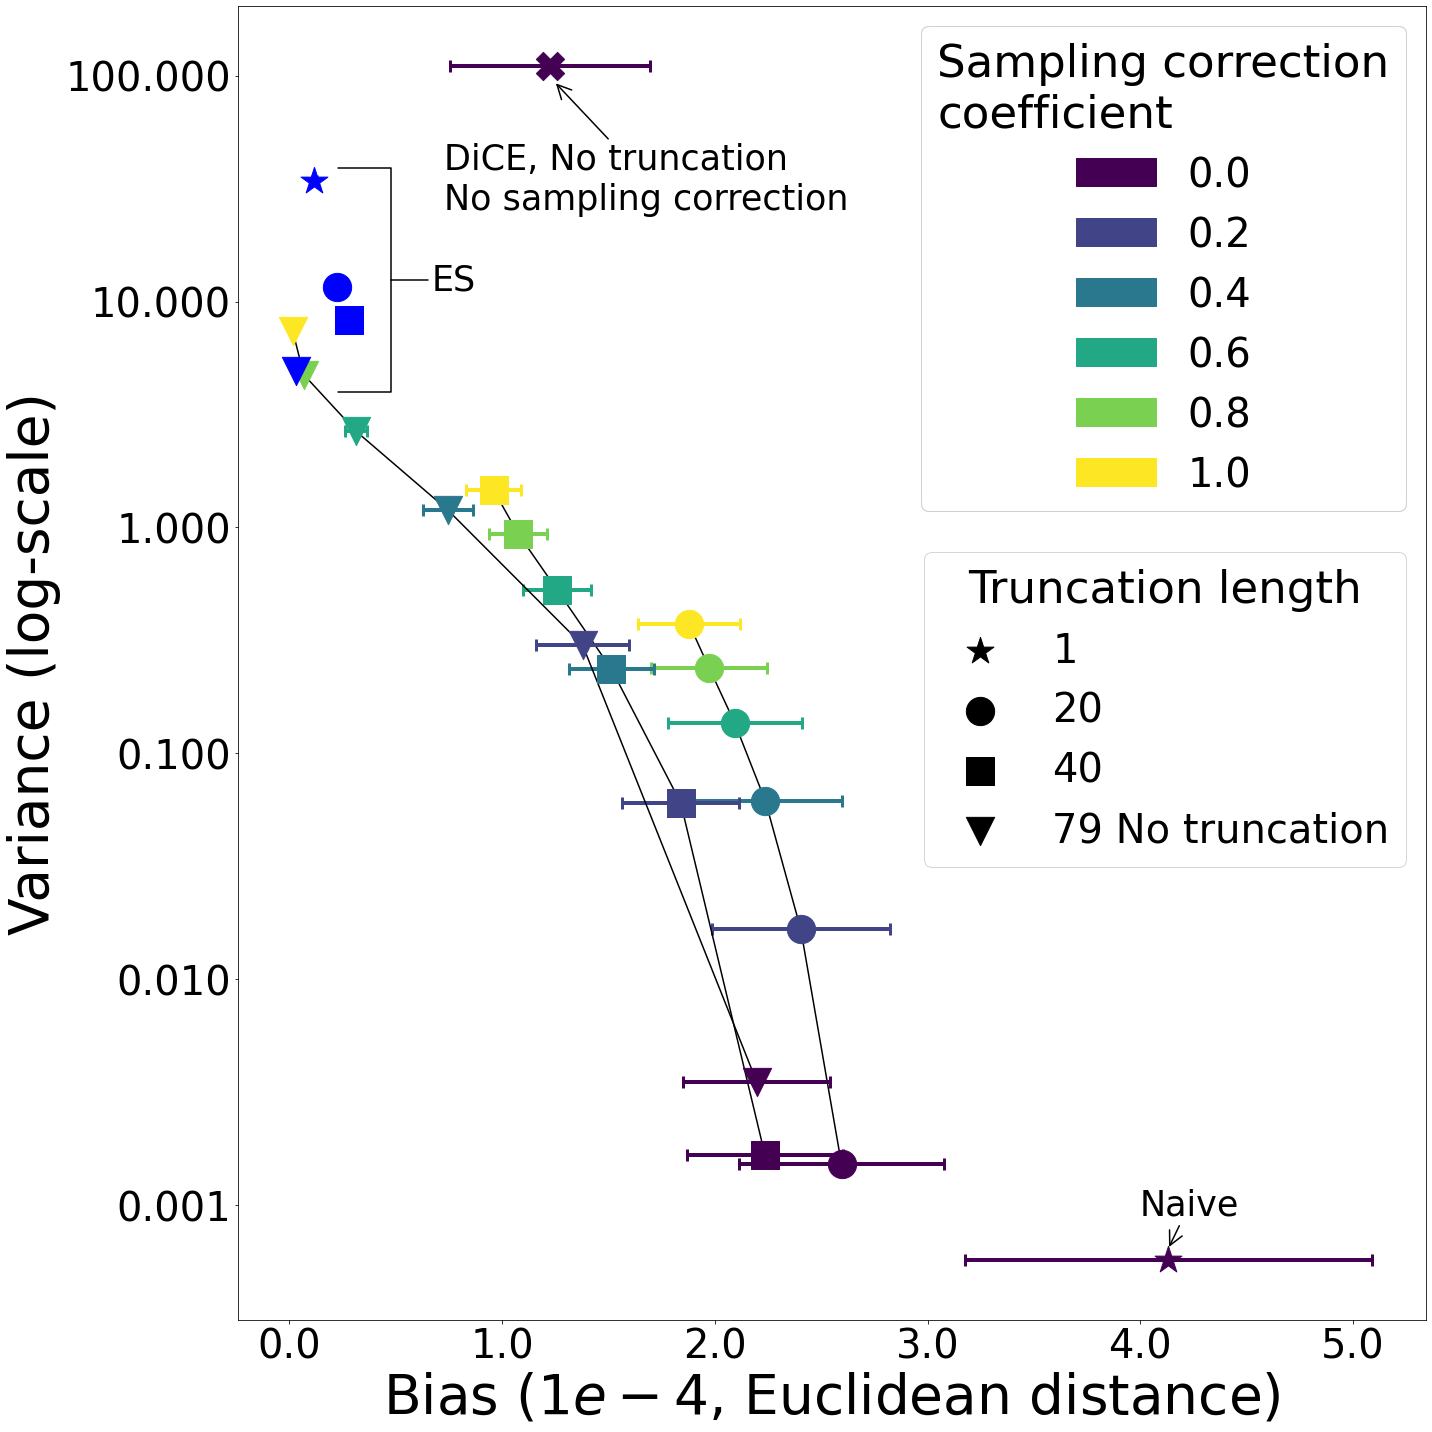

In [15]:

sideX = 1
sideY = 1
fig, axes = plt.subplots(sideY, sideX, figsize=(20 * sideX, 20 * sideY))


axes = onp.array(axes).flatten()
ax = axes[0]

trunc_len_to_marker = {v: k for k, v in zip(['*', 'o', 's', 'D', 'v', '+'], sorted(set([v[1] for v in all_variants])))}


e_lambdas = [0.0, 2.0, 4.0, 6.0, 8.0, 10.0]
trunc_lens = [
    2,
    21,
    41,
#     61,
    80,
]


for tl in trunc_lens:
    xs = []
    ys = []
    for el in e_lambdas:
        if (tl, el) in memo:
            stats = memo[(tl, el)]
        else:
            f = (True
                 & (DF.e_maml_lambda == el)
                 & (DF.truncation_length == tl)
            )
            if (tl == 2) and (el != 0.0):
                continue

            df = DF[f].reset_index().rename(columns={'eta_pg_g0': 'g0', 'eta_pg_g1': 'g1', 'eta_pg_g0_var': 'g0_var', 'eta_pg_g1_var': 'g1_var'})

            if len(df) == 0:
                continue

            stats = boostrap_ci_across_init_bias(FD_DF, df, 10000)
            memo[(tl, el)] = stats

        x = stats['mean_diff']
        xs.append(x)
        y = onp.log10(stats['mean_var'])
        ys.append(y)
        ax.scatter(
            x,
            y,
            color=plt.get_cmap('viridis')(el / DF.e_maml_lambda.unique().max()),
            marker=trunc_len_to_marker[tl],
            s=800,
        )
        ax.errorbar(
            x,
            y,
            xerr=onp.array(
                [
                    stats['std_diff'],
                    stats['std_diff']
#                     stats['q1_diff'],
#                     stats['q3_diff'],
                ]
            ).reshape(2, 1),
            color=plt.get_cmap('viridis')(el / DF.e_maml_lambda.unique().max()),
    #             color='black',
            capsize=6,
            capthick=3,
            linewidth=4,
            zorder=0,
        )
        if (tl == 30) and (el == 10.0):
            ax.annotate(
                'No truncation\nSampling corrected',
                xy=(x, y + 0.01),
                xytext=(x + 0.00005, y - 0.1),
                arrowprops=dict(arrowstyle="->", linewidth=1.5),
                fontsize=LEGEND_FONTSIZE + 10,
                va='center',
            )
        if (tl == 2) and (el == 0.0):
            ax.annotate(
                'Naive',
                xy=(x, y + 0.05),
                xytext=(x + 0.00001, y + 0.2),
                arrowprops=dict(arrowstyle="->", linewidth=1.5),
                fontsize=LEGEND_FONTSIZE + 10,
                ha='center',
            )
    plt.plot(xs, ys, color='black', linewidth=1.5,  zorder=0)


for trunc_len in sorted(trunc_lens):
    ax.scatter(
        [], [],
        color='black',
        marker=trunc_len_to_marker[trunc_len],
        s=800,
        label=f"{trunc_len-1 if trunc_len < 79 else '79 No truncation'}",
    )

l1 = ax.legend(
    fontsize=LEGEND_FONTSIZE+15,
    title='Truncation length',
    loc='upper right',
    title_fontsize=LEGEND_TITLE_FONTSIZE + 10,
    bbox_to_anchor=[1.0, 0.6],
)


import matplotlib.patches as mpatches

handles = []
for el in sorted(DF.e_maml_lambda.unique()):
    patch = mpatches.Patch(
        color=plt.get_cmap('viridis')(el / DF.e_maml_lambda.unique().max()),
        label=f"{el / 10.0 :1.1f}",
    )
    handles.append(patch)

l2 = ax.legend(
    handles=handles,
    fontsize=LEGEND_FONTSIZE+15,
    title='Sampling correction\ncoefficient',
    loc='upper right',
    title_fontsize=LEGEND_TITLE_FONTSIZE + 10,
)


# Add ES
for tl in trunc_lens:
    xs = []
    ys = []
    if (tl, 'ES') in memo:
        stats = memo[(tl, 'ES')]
    else:
        f = (True
             & (ES_DF.truncation_length == tl)
        )

        df = ES_DF[f].reset_index().rename(columns={'eta_es_g0': 'g0', 'eta_es_g1': 'g1', 'eta_es_g0_var': 'g0_var', 'eta_es_g1_var': 'g1_var'})

        if len(df) == 0:
            continue

        stats = boostrap_ci_across_init_bias(FD_DF, df, 10000)
        memo[(tl, 'ES')] = stats

    x = stats['mean_diff']
    xs.append(x)
    y = onp.log10(stats['mean_var'])
    ys.append(y)
    ax.scatter(
        x,
        y,
        color='blue',
#             color=plt.get_cmap('viridis')(el / DF.e_maml_lambda.unique().max()),
        marker=trunc_len_to_marker[tl],
        s=800,
    )
    ax.errorbar(
        x,
        y,
        xerr=onp.array(
            [
                stats['std_diff'],
                stats['std_diff']
#                     stats['q1_diff'],
#                     stats['q3_diff'],
            ]
        ).reshape(2, 1),
#             color=plt.get_cmap('viridis')(el / DF.e_maml_lambda.unique().max()),
#             color='black',
        capsize=6,
        capthick=3,
        linewidth=4,
        zorder=0,
    )
    plt.plot(xs, ys, color='black', linewidth=1.5,  zorder=0)

ax.annotate(
    'ES',
    xy=(0.27, 0.8),
    xycoords='figure fraction',
    xytext=(0.3, 0.8),
    arrowprops=dict(arrowstyle='-[, widthB=3.2, lengthB=1.5', linewidth=1.5),
    fontsize=LEGEND_FONTSIZE + 10,
    va='center',
)


# Adding dice
# ddf = D_DF[(D_DF.meta_discount == 0.0)].reset_index().rename(columns={'eta_pg_g0': 'g0', 'eta_pg_g1': 'g1', 'eta_pg_g0_var': 'g0_var', 'eta_pg_g1_var': 'g1_var'})
ddf = D_DF[(D_DF.e_maml_lambda == 0.0)].reset_index().rename(columns={'eta_pg_g0': 'g0', 'eta_pg_g1': 'g1', 'eta_pg_g0_var': 'g0_var', 'eta_pg_g1_var': 'g1_var'})
if 'dice' in memo:
    stats = memo['dice']
else:
    stats = boostrap_ci_across_init_bias(FD_DF, ddf, 10000)
    memo['dice'] = stats

x = stats['mean_diff']
y = onp.log10(stats['mean_var'])
h = ax.scatter(
    x,
    y,
    color=plt.get_cmap('viridis')(0.0),
    marker='X',
    s=800,
)
ax.annotate(
    'DiCE, No truncation\nNo sampling correction',
    xy=(x + 0.000002, y - 0.07),
    xytext=(x - 0.00005, y - 0.5),
    arrowprops=dict(arrowstyle="->", linewidth=1.5),
    fontsize=LEGEND_FONTSIZE + 10,
    va='center',
)
ax.errorbar(
    x,
    y,
    xerr=onp.array(
        [
            stats['std_diff'],
            stats['std_diff']
        ]
    ).reshape(2, 1),
    color=plt.get_cmap('viridis')(0.0),
    capsize=6,
    capthick=3,
    linewidth=4,
    zorder=0,
)



# ax.add_artist(leg)
ax.add_artist(l1)
ax.add_artist(l2)
# ax.add_artist(l3)



# legend2 = ax.legend(handles, labels, loc="upper right", title="Sizes")

ax.tick_params(axis='both', which='major', labelsize=TICK_SIZE + 10)
ax.yaxis.set_major_formatter(lambda x, pos: f"{10**x:1.3f}")
ax.xaxis.set_major_formatter(lambda x, pos: f"{x * 10000:1.1f}")

_=ax.set_xlabel('Bias ($1e-4$, Euclidean distance)', fontsize=AXIS_LABEL_SIZE)
_=ax.set_ylabel('Variance (log-scale)', fontsize=AXIS_LABEL_SIZE)

# _=ax.set_xlabel('Bias $(\log_{10})$', fontsize=36)
# _=ax.set_ylabel('Variance $(\log_{10})$', fontsize=36)

plt.tight_layout()
plt.savefig('bandit_bias_variance_frontier_longer_truncation_lengths.pdf')



# Cosine similarity across initialization

In [17]:
memo2 = {}

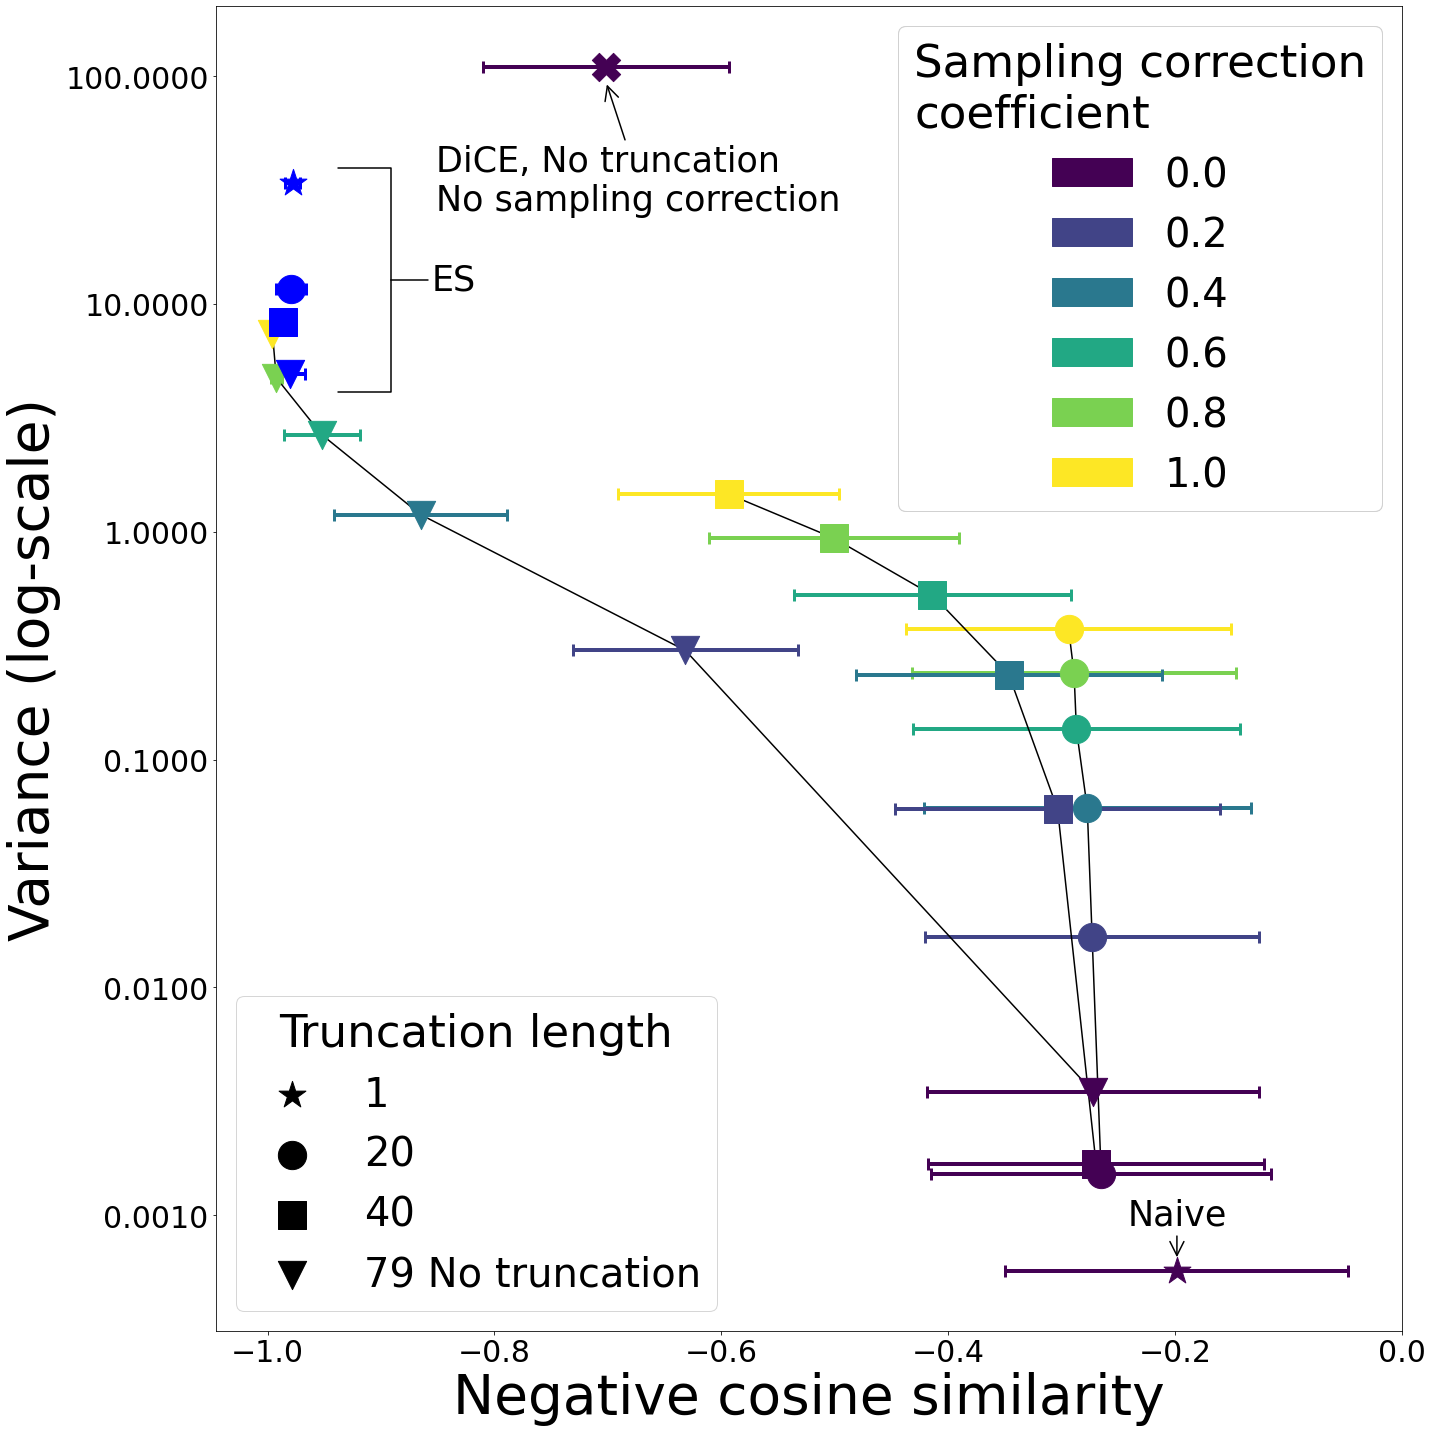

In [36]:

def boostrap_ci_across_init_coss(base_df, grad_df, repetitions):
    all_eta_inits = base_df.groupby(['init_eta0', 'init_eta1']
        ).count().reset_index()[['init_eta0', 'init_eta1']]
    bootstrap_sample_size = len(all_eta_inits)
    inner_memo = {}

    diffs = []
    variances = []
    for i in range(repetitions):
        if repetitions == 1:
            unique_eta_inits = all_eta_inits.to_numpy()
        else:
#             sample = df.sample(n=bootstrap_sample_size, replace=True)
            unique_eta_inits = all_eta_inits.sample(n=bootstrap_sample_size, replace=True).to_numpy()
        
        mean_differences = []
        estimator_variances = []
        for eta0, eta1 in unique_eta_inits:
            if (eta0, eta1) in inner_memo:
                mean_difference, var0, var1 = inner_memo[(eta0, eta1)]
            else:
                grad_df_ = grad_df[(grad_df.init_eta0 == eta0) & (grad_df.init_eta1 == eta1)]
                if len(grad_df_) == 0:
                    continue
                pgg = grad_df_[['g0', 'g1']].to_numpy().mean(axis=0)
                fd_df_ = base_df[(base_df.init_eta0 == eta0) & (FD_DF.init_eta1 == eta1)]
                fdg = fd_df_[['eta_fd_g0', 'eta_fd_g1']].to_numpy().mean(axis=0)

                mean_difference = onp.vdot(fdg, pgg) / (onp.linalg.norm(fdg) * onp.linalg.norm(pgg))
                pg0_mean = grad_df_['g0']
                pg0_var = grad_df_['g0_var']
                
                if 'popsize' in grad_df.columns:
                    parallel_runs = grad_df.parallel_runs.unique()[0] * grad_df.popsize.unique()[0]
                else:
                    parallel_runs = grad_df.parallel_runs.unique()[0]
                
                counts = onp.ones_like(pg0_var) * parallel_runs
                size = len(pg0_var) * parallel_runs
                _, var0 = combine(pg0_mean, pg0_var, counts, size)

                pg1_mean = grad_df_['g1']
                pg1_var = grad_df_['g1_var']
                counts = onp.ones_like(pg1_var) * parallel_runs
                size = len(pg1_var) * parallel_runs
                _, var1 = combine(pg1_mean, pg1_var, counts, size)
                inner_memo[(eta0, eta1)] = (mean_difference, var0, var1)

            mean_differences.append(mean_difference)
            estimator_variances.append(var0 + var1)
        diffs.append(onp.mean(mean_differences))
        variances.append(onp.mean(estimator_variances))
    item = {
        'mean_diff': onp.mean(diffs),
        'med_diff': onp.median(diffs),
        'std_diff': onp.std(diffs),
        'q1_diff': onp.percentile(diffs, 25),
        'q3_diff': onp.percentile(diffs, 75),
        'whislo_diff': onp.min(diffs),
        'whishi_diff': onp.max(diffs),
        
        'mean_var': onp.mean(variances),
        'med_var': onp.median(variances),
        'q1_var': onp.percentile(variances, 25),
        'q3_var': onp.percentile(variances, 75),
        'whislo_var': onp.min(variances),
        'whishi_var': onp.max(variances),
    }
    return item


sideX = 1
sideY = 1
fig, axes = plt.subplots(sideY, sideX, figsize=(20 * sideX, 20 * sideY))


axes = onp.array(axes).flatten()
ax = axes[0]

trunc_len_to_marker = {v: k for k, v in zip(['*', 'o', 's', 'D', 'v', '+'], sorted(set([v[1] for v in all_variants])))}


e_lambdas = [0.0, 2.0, 4.0, 6.0, 8.0, 10.0]
trunc_lens = [
    2,
    21,
    41,
#     61,
    80,
]


for tl in trunc_lens:
    xs = []
    ys = []
    for el in e_lambdas:
        if (tl, el) in memo2:
            stats = memo2[(tl, el)]
        else:
            f = (True
                 & (DF.e_maml_lambda == el)
                 & (DF.truncation_length == tl)
            )
            if (tl == 2) and (el != 0.0):
                continue

            df = DF[f].reset_index().rename(columns={'eta_pg_g0': 'g0', 'eta_pg_g1': 'g1', 'eta_pg_g0_var': 'g0_var', 'eta_pg_g1_var': 'g1_var'})

            if len(df) == 0:
                continue

            stats = boostrap_ci_across_init_coss(FD_DF, df, 10000)
            memo2[(tl, el)] = stats

        x = -stats['mean_diff']
        xs.append(x)
        y = onp.log10(stats['mean_var'])
        ys.append(y)
        ax.scatter(
            x,
            y,
            color=plt.get_cmap('viridis')(el / DF.e_maml_lambda.unique().max()),
            marker=trunc_len_to_marker[tl],
            s=800,
        )
        ax.errorbar(
            x,
            y,
            xerr=onp.array(
                [
                    stats['std_diff'],
                    stats['std_diff']
#                     stats['q1_diff'],
#                     stats['q3_diff'],
                ]
            ).reshape(2, 1),
            color=plt.get_cmap('viridis')(el / DF.e_maml_lambda.unique().max()),
    #             color='black',
            capsize=6,
            capthick=3,
            linewidth=4,
            zorder=0,
        )
        if (tl == 30) and (el == 10.0):
            ax.annotate(
                'No truncation\nSampling corrected',
                xy=(x, y + 0.01),
                xytext=(x + 0.00005, y - 0.1),
                arrowprops=dict(arrowstyle="->", linewidth=1.5),
                fontsize=LEGEND_FONTSIZE + 10,
                va='center',
            )
        if (tl == 2) and (el == 0.0):
            ax.annotate(
                'Naive',
                xy=(x, y + 0.05),
                xytext=(x + 0.00001, y + 0.2),
                arrowprops=dict(arrowstyle="->", linewidth=1.5),
                fontsize=LEGEND_FONTSIZE + 10,
                ha='center',
            )
    plt.plot(xs, ys, color='black', linewidth=1.5,  zorder=0)




for trunc_len in sorted(trunc_lens):
    ax.scatter(
        [], [],
        color='black',
        marker=trunc_len_to_marker[trunc_len],
        s=800,
        label=f"{trunc_len-1 if trunc_len < 79 else '79 No truncation'}",
    )


l1 = ax.legend(
    fontsize=LEGEND_FONTSIZE + 15,
    title='Truncation length',
    loc='lower left',
    title_fontsize=LEGEND_TITLE_FONTSIZE + 10,
#     bbox_to_anchor=[0.3, 1.0],
)



import matplotlib.patches as mpatches

handles = []
for el in sorted(DF.e_maml_lambda.unique()):
    patch = mpatches.Patch(
        color=plt.get_cmap('viridis')(el / DF.e_maml_lambda.unique().max()),
        label=f"{el / 10.0 :1.1f}",
    )
    handles.append(patch)


l2 = ax.legend(
    handles=handles,
    fontsize=LEGEND_FONTSIZE + 15,
    title='Sampling correction\ncoefficient',
    loc='upper right',
    title_fontsize=LEGEND_TITLE_FONTSIZE+10,
)


# Add ES
for tl in trunc_lens:
    xs = []
    ys = []
    if (tl, 'ES') in memo2:
        stats = memo2[(tl, 'ES')]
    else:
        f = (True
             & (ES_DF.truncation_length == tl)
        )

        df = ES_DF[f].reset_index().rename(columns={'eta_es_g0': 'g0', 'eta_es_g1': 'g1', 'eta_es_g0_var': 'g0_var', 'eta_es_g1_var': 'g1_var'})

        if len(df) == 0:
            continue
        stats = boostrap_ci_across_init_coss(FD_DF, df, 10000)
        memo2[(tl, 'ES')] = stats

    x = -stats['mean_diff']
    xs.append(x)
    y = onp.log10(stats['mean_var'])
    ys.append(y)
    ax.scatter(
        x,
        y,
        color='blue',
#             color=plt.get_cmap('viridis')(el / DF.e_maml_lambda.unique().max()),
        marker=trunc_len_to_marker[tl],
        s=800,
    )
    ax.errorbar(
        x,
        y,
        xerr=onp.array(
            [
                stats['std_diff'],
                stats['std_diff']
#                     stats['q1_diff'],
#                     stats['q3_diff'],
            ]
        ).reshape(2, 1),
#             color=plt.get_cmap('viridis')(el / DF.e_maml_lambda.unique().max()),
        color='blue',
        capsize=6,
        capthick=3,
        linewidth=4,
        zorder=0,
    )
    plt.plot(xs, ys, color='black', linewidth=1.5,  zorder=0)

ax.annotate(
    'ES',
    xy=(0.27, 0.8),
    xycoords='figure fraction',
    xytext=(0.3, 0.8),
    arrowprops=dict(arrowstyle='-[, widthB=3.2, lengthB=1.5', linewidth=1.5),
    fontsize=LEGEND_FONTSIZE + 10,
    va='center',
)


# Adding dice
# ddf = D_DF[(D_DF.meta_discount == 0.0)].reset_index().rename(columns={'eta_pg_g0': 'g0', 'eta_pg_g1': 'g1', 'eta_pg_g0_var': 'g0_var', 'eta_pg_g1_var': 'g1_var'})
ddf = D_DF[(D_DF.e_maml_lambda == 0.0)].reset_index().rename(columns={'eta_pg_g0': 'g0', 'eta_pg_g1': 'g1', 'eta_pg_g0_var': 'g0_var', 'eta_pg_g1_var': 'g1_var'})
if 'dice' in memo2:
    stats = memo2['dice']
else:
    stats = boostrap_ci_across_init_coss(FD_DF, ddf, 10000)
    memo2['dice'] = stats

x = -stats['mean_diff']
y = onp.log10(stats['mean_var'])
h = ax.scatter(
    x,
    y,
    color=plt.get_cmap('viridis')(0.0),
    marker='X',
    s=800,
)
ax.annotate(
    'DiCE, No truncation\nNo sampling correction',
    xy=(x + 0.000002, y - 0.07),
    xytext=(x - 0.15, y - 0.5),
    arrowprops=dict(arrowstyle="->", linewidth=1.5),
    fontsize=LEGEND_FONTSIZE + 10,
    va='center',
)
ax.errorbar(
    x,
    y,
    xerr=onp.array(
        [
            stats['std_diff'],
            stats['std_diff']
        ]
    ).reshape(2, 1),
    color=plt.get_cmap('viridis')(0.0),
    capsize=6,
    capthick=3,
    linewidth=4,
    zorder=0,
)



# ax.add_artist(leg)
ax.add_artist(l1)
ax.add_artist(l2)
# ax.add_artist(l3)



ax.tick_params(axis='both', which='major', labelsize=TICK_SIZE)
ax.yaxis.set_major_formatter(lambda x, pos: f"{10**x:1.4f}")

_=ax.set_xlabel('Negative cosine similarity', fontsize=AXIS_LABEL_SIZE)
_=ax.set_ylabel('Variance (log-scale)', fontsize=AXIS_LABEL_SIZE)


plt.tight_layout()
plt.savefig('bandit_bias_variance_frontier_coss_longer_truncation_lengths.pdf')


In [159]:
#                  & (DF.e_maml_lambda == el)
#              & (DF.truncation_length == tl)
sum(DF.truncation_length == 23.0)

150000

# Compare meta-discount and e-maml

In [87]:
experiment_dirs = [
    '~/ray_results/on_policy_bandits:learn_lr_schedule:lt_len_30:noise_2:sweep_trunc:sweep_meta_discount:more_samples'
]

grad_dfs = []

param_classes = [
    'inner_loss',
    'truncation_length',
    'meta_discount',
    'e_maml_lambda',
]

for d in experiment_dirs:
    for path in glob.glob(os.path.join(d, '**/params.json')):
        with open(path, 'r') as f:
            params = pd.json_normalize(json.load(f))
        eta_init = params['initial_eta'].item()
        for rpath in glob.glob(os.path.join(os.path.dirname(path), '**/*.csv')):
            df = pd.read_csv(rpath)
            df['init_eta0'] = eta_init[0]
            df['init_eta1'] = eta_init[1]
            df['seed'] = params['seed'].item()
            for c in param_classes:
                if params[c].item() is None:
                    df[c] = 'deadbeef'
                else:
                    df[c] = params[c].item()
            grad_dfs.append(df)

E_DF = pd.concat(grad_dfs)




In [88]:
memo3 = {}

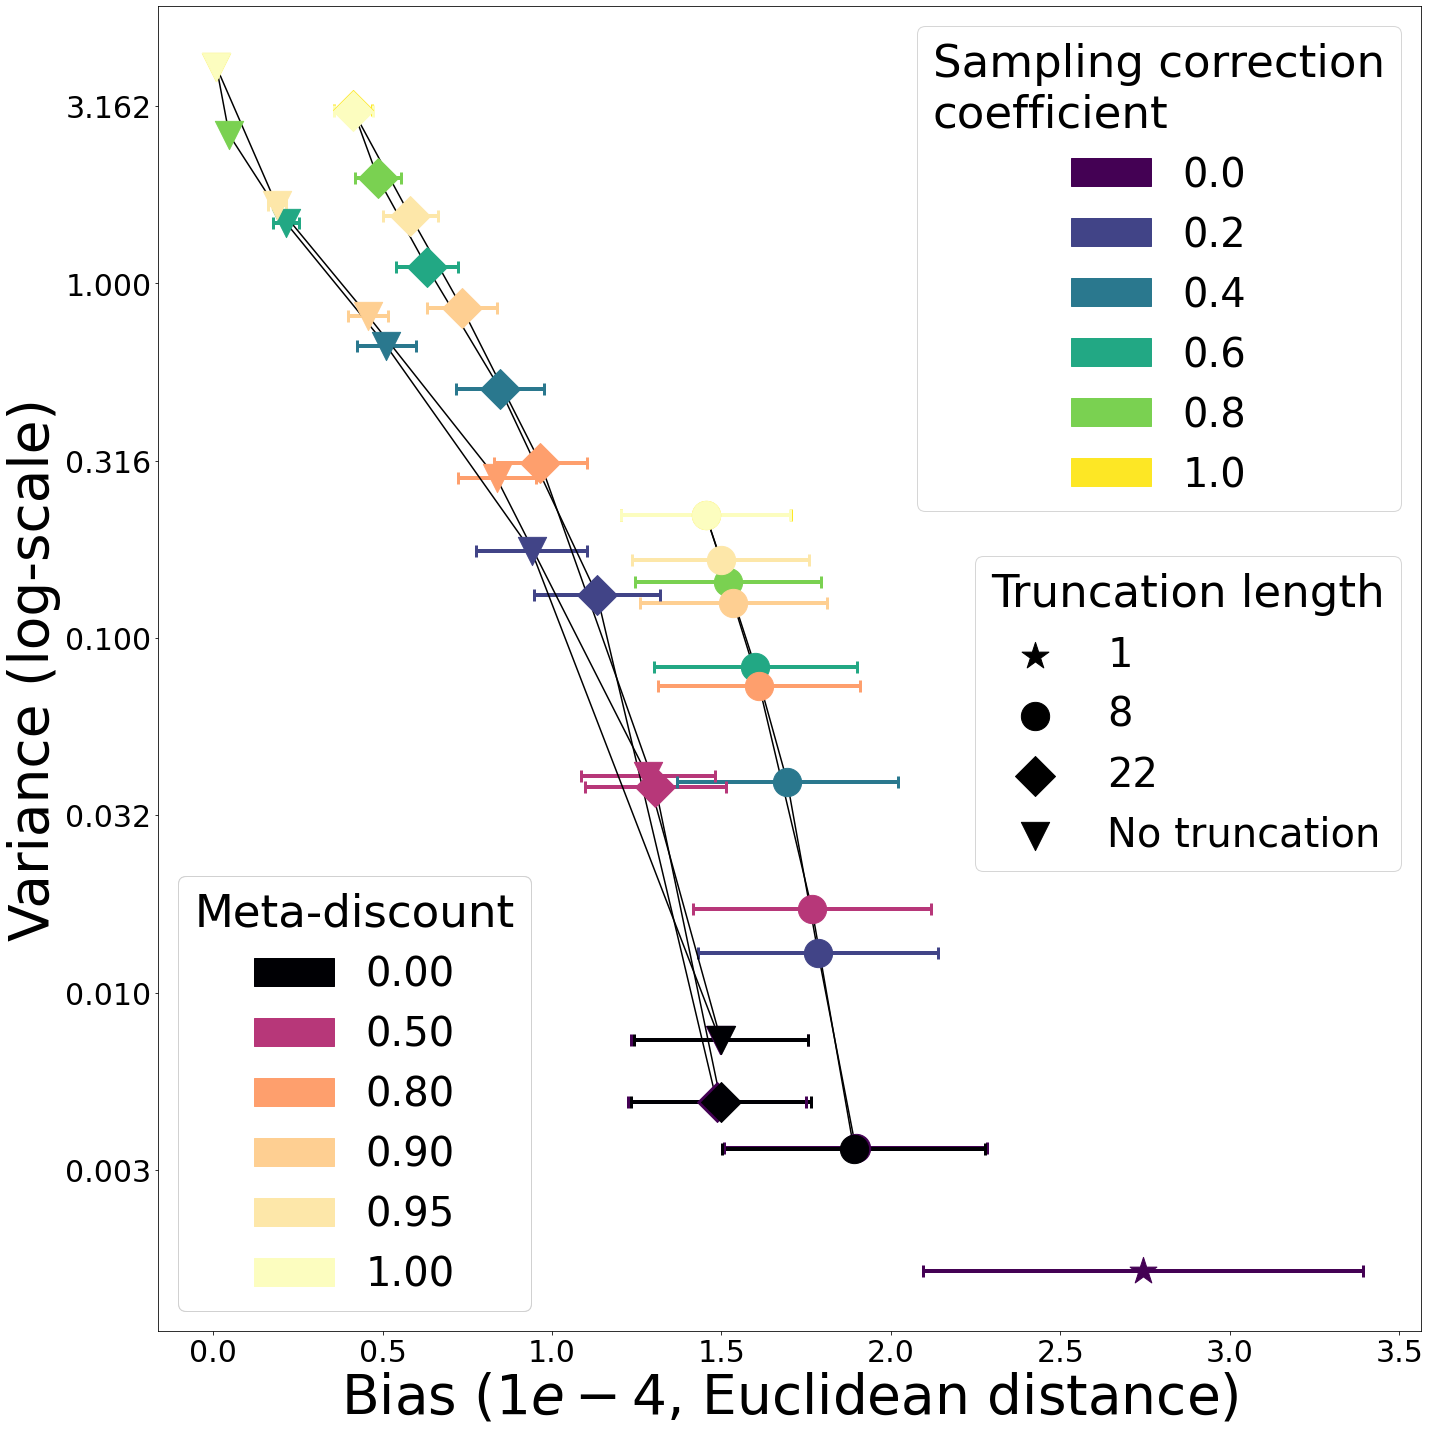

In [93]:
sideX = 1
sideY = 1
fig, axes = plt.subplots(sideY, sideX, figsize=(20 * sideX, 20 * sideY))


axes = onp.array(axes).flatten()
ax = axes[0]

trunc_len_to_marker = {v: k for k, v in zip(['*', 'o', 's', 'D', 'v', '+'], sorted(set([v[1] for v in all_variants])))}


e_lambdas = [0.0, 2.0, 4.0, 6.0, 8.0, 10.0]
meta_discounts = [0.0, 0.5, 0.8, 0.9, 0.95, 1.0]
trunc_lens = [2, 9, 23, 30]


for tl in trunc_lens:
    xs = []
    ys = []
    for el in e_lambdas:
        if (el, tl) in memo:
            stats = memo[(el, tl)]
        else:
            f = (True
                 & (DF.meta_discount == 1.0)
                 & (DF.e_maml_lambda == el)
                 & (DF.truncation_length == tl)
            )
            if (tl == 2) and (el != 0.0):
                continue

            df = DF[f].reset_index()

            if len(df) == 0:
                continue

            stats = boostrap_ci_across_init_bias(df, 10000)
            memo[(el, tl)] = stats

        x = stats['mean_diff']
        xs.append(x)
        y = onp.log10(stats['mean_var'])
        ys.append(y)
        ax.scatter(
            x,
            y,
            color=plt.get_cmap('viridis')(el / DF.e_maml_lambda.unique().max()),
            marker=trunc_len_to_marker[tl],
            s=800,
            zorder=3,
        )
        ax.errorbar(
            x,
            y,
            xerr=onp.array(
                [
                    stats['std_diff'],
                    stats['std_diff']
#                     stats['q1_diff'],
#                     stats['q3_diff'],
                ]
            ).reshape(2, 1),
            color=plt.get_cmap('viridis')(el / DF.e_maml_lambda.unique().max()),
    #             color='black',
            capsize=6,
            capthick=3,
            linewidth=4,
            zorder=0,
        )

    plt.plot(xs, ys, color='black', linewidth=1.5,  zorder=0)
    xs = []
    ys = []
    for md in meta_discounts:
        if (md == 0) and (tl == 2):
            continue
        if (md, tl) in memo3:
            stats = memo3[(md, tl)]
        else:
            f = (True
                 & (E_DF.e_maml_lambda == 1.0)
                 & (E_DF.meta_discount == md)
                 & (E_DF.truncation_length == tl)
            )
            if (tl == 2) and (md != 0.0):
                continue

            df = E_DF[f].reset_index()

            if len(df) == 0:
                continue

            stats = boostrap_ci_across_init_bias(df, 10000)
            memo3[(md, tl)] = stats

        x = stats['mean_diff']
        xs.append(x)
        y = onp.log10(stats['mean_var'])
        ys.append(y)
        ax.scatter(
            x,
            y,
            color=plt.get_cmap('magma')(md),
            marker=trunc_len_to_marker[tl],
            s=800,
            zorder=4,
        )
        ax.errorbar(
            x,
            y,
            xerr=onp.array(
                [
                    stats['std_diff'],
                    stats['std_diff']
#                     stats['q1_diff'],
#                     stats['q3_diff'],
                ]
            ).reshape(2, 1),
            color=plt.get_cmap('magma')(md),
    #             color='black',
            capsize=6,
            capthick=3,
            linewidth=4,
            zorder=0,
        )

    plt.plot(xs, ys, color='black', linewidth=1.5,  zorder=1)
    
for trunc_len in sorted(trunc_lens):
    ax.scatter(
        [], [],
        color='black',
        marker=trunc_len_to_marker[trunc_len],
        s=800,
        label=f"{trunc_len-1 if trunc_len < 29 else 'No truncation'}",
    )

l1 = ax.legend(
    fontsize=LEGEND_FONTSIZE + 15,
    title='Truncation length',
    loc='upper right',
    title_fontsize=LEGEND_TITLE_FONTSIZE + 10,
    bbox_to_anchor=[1.0, 0.60],
)


import matplotlib.patches as mpatches

handles = []
for el in sorted(DF.e_maml_lambda.unique()):
    patch = mpatches.Patch(
        color=plt.get_cmap('viridis')(el / DF.e_maml_lambda.unique().max()),
        label=f"{el / 10.0 :1.1f}",
    )
    handles.append(patch)

l2 = ax.legend(
    handles=handles,
    fontsize=LEGEND_FONTSIZE + 15,
    title='Sampling correction\ncoefficient',
    loc='upper right',
    title_fontsize=LEGEND_TITLE_FONTSIZE + 10,
)



handles = []
for meta_discount in sorted(meta_discounts):
    patch = mpatches.Patch(
        color=plt.get_cmap('magma')(meta_discount),
        label=f"{meta_discount:1.2f}",
    )
    handles.append(patch)

l3 = ax.legend(
    handles=handles,
    fontsize=LEGEND_FONTSIZE + 15,
    title='Meta-discount',
    loc='lower left',
    title_fontsize=LEGEND_TITLE_FONTSIZE + 10,
    # bbox_to_anchor=[0.68, 1.0],
)


ax.add_artist(l1)
ax.add_artist(l2)
ax.add_artist(l3)




# legend2 = ax.legend(handles, labels, loc="upper right", title="Sizes")

ax.tick_params(axis='both', which='major', labelsize=TICK_SIZE)
ax.yaxis.set_major_formatter(lambda x, pos: f"{10**x:1.3f}")
ax.xaxis.set_major_formatter(lambda x, pos: f"{x * 10000:1.1f}")

_=ax.set_xlabel('Bias ($1e-4$, Euclidean distance)', fontsize=AXIS_LABEL_SIZE)
_=ax.set_ylabel('Variance (log-scale)', fontsize=AXIS_LABEL_SIZE)


# _=ax.set_xlabel('Bias $(\log_{10})$', fontsize=36)
# _=ax.set_ylabel('Variance $(\log_{10})$', fontsize=36)

plt.tight_layout()
plt.savefig('bandit_bias_variance_frontier_compare_meta_discount.pdf')
# plt.savefig('bandit_bias_variance_frontier.pdf')


## Remove the batch size from here. Do not name this after E-MAML.
